In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
torch.manual_seed(0)

/tmp/work/miniconda3/envs/yutung/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Load image

In [2]:
# Directory path
training_data = "///tmp/dataset-ncku-ml/train" # 'path to your training data'

# List to store the names of subfolders (sample IDs)
sample_ids = []

# Iterate over the items in the directory
for item in os.listdir(training_data):
    item_path = os.path.join(training_data, item)
    if os.path.isdir(item_path):
        sample_ids.append(item)

# Iterate over the items in the directory (limit to first 10 folders)
for idx, item in enumerate(sorted(os.listdir(training_data))):
    if idx >= 50:  # Only take the first n folders
        break
    item_path = os.path.join(training_data, item)
    if os.path.isdir(item_path):
        sample_ids.append(item)

print("Sample IDs:\n", sample_ids[:5])

Sample IDs:
 ['2023-10-05_3bfb8d59', '2023-10-05_d98cecb8', '2023-10-05_11341184', '2023-10-05_7d38d9f0', '2023-10-05_c2c9da2e']


In [3]:
# Choosing one of the samples
sample_id = sample_ids[0]

# Path to the subfolder/sample
sample_path = os.path.join(training_data, sample_id)

# List and print all files in the sample subfolder
files = os.listdir(sample_path)
print("\n Files in the sample subfolder:", files)

# Iterate over the files and load the .npy files.
for file in files:
    if file.startswith("seismicCubes_") and file.endswith(".npy"):
        seismic = np.load(os.path.join(sample_path, file), allow_pickle=True)
    elif file.startswith("fault_") and file.endswith(".npy"):
        fault = np.load(os.path.join(sample_path, file), allow_pickle=True)

print(
    f"\n Seismic array is of the shape: {seismic.shape} and of the data type: {seismic.dtype}"
)
print(
    f" Faults array is of the shape: {fault.shape} and of the data type: {fault.dtype}"
)


 Files in the sample subfolder: ['fault_segments_2023.76154658.npy', 'seismicCubes_RFC_fullstack_2023.76154658.npy']

 Seismic array is of the shape: (300, 300, 1259) and of the data type: float64
 Faults array is of the shape: (300, 300, 1259) and of the data type: uint8


# 2. 可視化

In [4]:
def plot_seismic_and_fault(seismic, fault, line_type, line_num):
    """
    Visualize seismic data with fault overlay and pure fault image.

    Parameters:
        seismic (numpy.ndarray): Seismic volume.
        fault (numpy.ndarray): Fault volume (binary mask).
        line_type (str): Type of line to plot ('inline' or 'xline').
        line_num (int): Line number to visualize.
    """
    if line_type not in ['inline', 'xline']:
        raise ValueError("line_type must be either 'inline' or 'xline'")

    # Determine the slicing direction based on line type
    if line_type == 'inline':
        seismic_slice = seismic[line_num, :, :].T
        fault_slice = fault[line_num, :, :].T
    elif line_type == 'xline':
        seismic_slice = seismic[:, line_num, :].T
        fault_slice = fault[:, line_num, :].T

    # Plot the seismic slice with fault overlay
    plt.figure(figsize=(12, 6))

    # Plot seismic with fault overlay
    plt.subplot(1, 2, 1)
    plt.imshow(seismic_slice, cmap='seismic')
    plt.imshow(fault_slice, cmap='Greys', vmin=0, vmax=1, alpha=0.3)  # Overlay fault
    plt.title(f"Seismic with Fault Overlay ({line_type.capitalize()} {line_num})")

    # Plot pure fault image
    plt.subplot(1, 2, 2)
    plt.imshow(fault_slice, cmap='gray', vmin=0, vmax=1)
    plt.title(f"Pure Fault Image ({line_type.capitalize()} {line_num})")

    plt.tight_layout()
    plt.show()


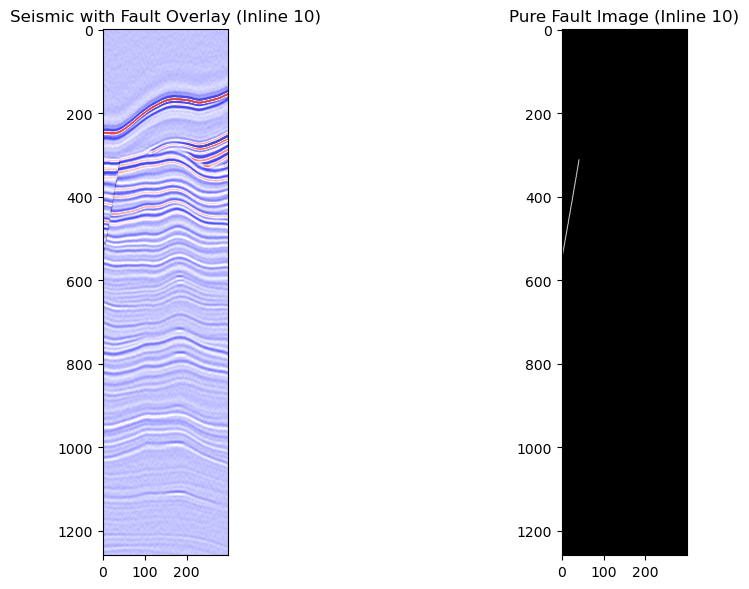

In [5]:
plot_seismic_and_fault(seismic, fault, line_type='inline', line_num=10)

# 3. 數據分割與 DataLoader

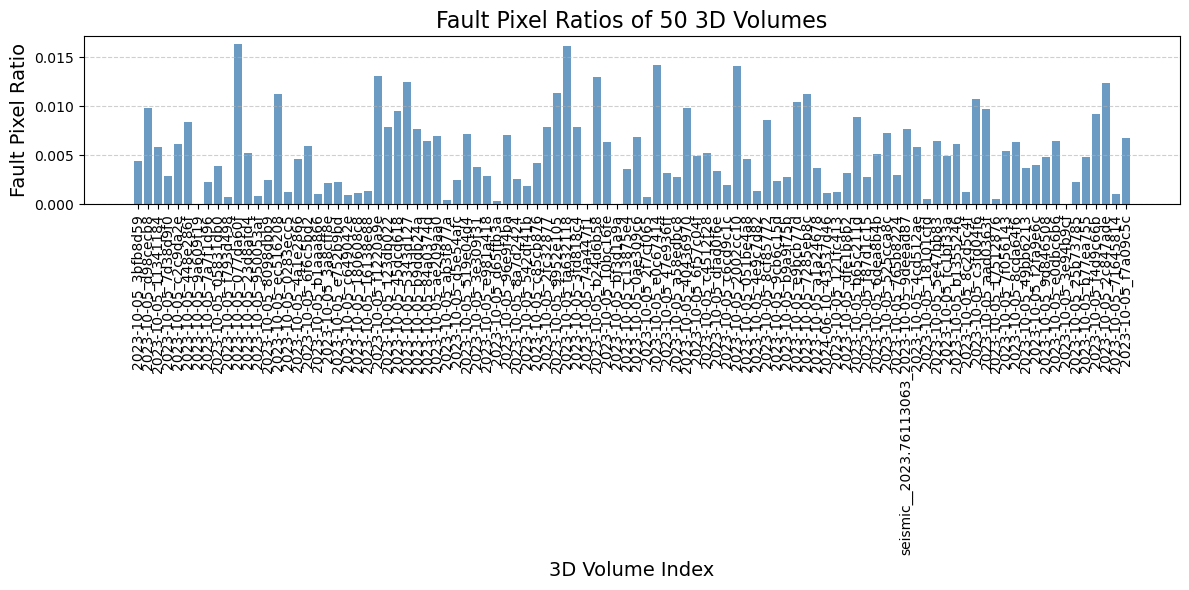

0.0053137459182772935


In [6]:
data_path = training_data

# 取得樣本 IDs (只取前 25 和後 25 張 3D 圖像)
all_sample_ids = [
    item for item in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, item))
]
sample_ids = all_sample_ids[:50] + all_sample_ids[-50:]

# 初始化統計數據
fault_pixel_ratios = []

# 遍歷樣本計算 fault pixel 占比
for sample_id in sample_ids:
    sample_dir = os.path.join(data_path, sample_id)
    
    # 加載 Fault Data (假設故障數據文件是第一個文件)
    file_names = sorted(os.listdir(sample_dir))
    fault_file = os.path.join(sample_dir, file_names[0])
    fault_data = np.load(fault_file)  # (depth, height, width)
    
    # 計算 Fault Pixel 的數量與總像素數
    total_pixels = fault_data.size
#     print(total_pixels)
    fault_pixels = np.sum(fault_data != 0)
    fault_pixel_ratio = fault_pixels / total_pixels
    
    # 儲存到列表
    fault_pixel_ratios.append(fault_pixel_ratio)

# 繪製 Fault Pixel 占比的圖表
plt.figure(figsize=(12, 6))
plt.bar(range(len(fault_pixel_ratios)), fault_pixel_ratios, color='steelblue', alpha=0.8)
plt.xlabel("3D Volume Index", fontsize=14)
plt.ylabel("Fault Pixel Ratio", fontsize=14)
plt.title("Fault Pixel Ratios of 50 3D Volumes", fontsize=16)
plt.xticks(range(len(fault_pixel_ratios)), sample_ids, rotation=90, fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# # 繪製 Fault Pixel 占比的圖表
# plt.figure(figsize=(12, 6))
# plt.bar(range(len(fault_pixel_ratios_1)), fault_pixel_ratios_1, color='red', alpha=0.8)
# plt.xlabel("3D Volume Index", fontsize=14)
# plt.ylabel("Fault Pixel Ratio", fontsize=14)
# plt.title("Fault Pixel Ratios of 50 3D Volumes after", fontsize=16)
# plt.xticks(range(len(fault_pixel_ratios_1)), sample_ids, rotation=90, fontsize=10)
# plt.tight_layout()
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.show()

# mean calculation
mean = 0
for ratio in fault_pixel_ratios:
    mean += ratio
mean = mean / 100
print(mean)

# 篩選fault ratio >= mean之3D資料
selected_sample_ids = [
    sample_id for sample_id, ratio in zip(sample_ids, fault_pixel_ratios) if ratio >= mean
]

In [7]:
class LargeSeismicDataset(Dataset):
    def __init__(self, data_path, slice_dim="depth", fault_threshold=0.01):
        """
        :param data_path: 資料路徑
        :param slice_dim: 切片方向，目前僅支援 "depth"
        :param fault_threshold: 故障像素數比例的閾值，默認為 1%（0.01）
        """
        self.data_path = data_path
        self.slice_dim = slice_dim
        self.fault_threshold = fault_threshold

        # 取得樣本 IDs
#         max_folders = 400
#         all_sample_ids = [
#             item for item in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, item))
#         ]
#         self.sample_ids = all_sample_ids[:50] + all_sample_ids[-50:]
#         self.sample_ids = all_sample_ids[:max_folders]
        self.sample_ids = selected_sample_ids
    
        # 建立全域索引，僅篩選有效切片
        self.global_indices = []
        for sample_idx, sample_id in enumerate(self.sample_ids):
            sample_dir = os.path.join(data_path, sample_id)
            seismic_file = os.path.join(sample_dir, sorted(os.listdir(sample_dir))[1])
            fault_file = os.path.join(sample_dir, sorted(os.listdir(sample_dir))[0])
            
#             print(seismic_file)
#             print(fault_file)

            # 加載故障數據以篩選有效切片
            fault_data = np.load(fault_file)  # (depth, height, width)
            num_slices = fault_data.shape[0] if slice_dim == "depth" else None
            total_pixels = fault_data.shape[1] * fault_data.shape[2]

            # 篩選符合閾值的切片
            for slice_idx in range(num_slices):
                fault_pixels = np.sum(fault_data[slice_idx, :, :] != 0)
#                 print("fault_pixels = ", fault_pixels, " / total_pixels = ", total_pixels)
#                 if fault_pixels / total_pixels >= self.fault_threshold:  # 判斷是否有效
#                     self.global_indices.append((sample_idx, slice_idx))
                if fault_pixels > 0:  # 判斷是否有效
                    self.global_indices.append((sample_idx, slice_idx))
        
        print(f"Total valid 2D slices after filtering: {len(self.global_indices)}")

    def __len__(self):
        return len(self.global_indices)
    
    def __getitem__(self, idx):
        # 取得樣本與切片索引
        sample_idx, slice_idx = self.global_indices[idx]
        sample_id = self.sample_ids[sample_idx]
        sample_dir = os.path.join(self.data_path, sample_id)

        # 加載 3D 地震數據與故障數據
        file_names = sorted(os.listdir(sample_dir))
        seismic_file = os.path.join(sample_dir, file_names[1])  # 假設命名一致
        fault_file = os.path.join(sample_dir, file_names[0])
        seismic_data = np.load(seismic_file)  # (depth, height, width)
        fault_data = np.load(fault_file)      # (depth, height, width)

        # 提取特定的 2D 切片
        if self.slice_dim == "depth":
            image_2d = torch.tensor(seismic_data[slice_idx, :, :], dtype=torch.float32).unsqueeze(0)  # (1, height, width)
            label_2d = torch.tensor(fault_data[slice_idx, :, :], dtype=torch.float32).unsqueeze(0)     # (1, height, width)
        else:
            raise NotImplementedError("Only slicing along depth is currently implemented.")
        
        return image_2d, label_2d


In [8]:
# 使用 Dataset 和 DataLoader
dataset = LargeSeismicDataset(data_path=training_data, slice_dim="depth")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# 查看单个 batch
for batch_idx, (images, labels) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}:")
#     print(images)
    print(f"Images shape: {images.shape}")  # (batch_size, 1, height, width)
    print(f"Labels shape: {labels.shape}")  # (batch_size, 1, height, width)
    break

Total valid 2D slices after filtering: 11441
Batch 1:
Images shape: torch.Size([4, 1, 300, 1259])
Labels shape: torch.Size([4, 1, 300, 1259])


### Contracting Path
The contracting path is the encoder section of the U-Net which involves several downsampling steps.
It consists of the repeated application of two 3x3 convolutions (unpadded), each followed by a ReLU and 2x2 max pooling operation with stride of 2 for downsampling. At each downsampling step we double the number of feature channels.
Note: in the original U-Net framework, the resulting output has smaller size than the input. I am using a padding of (1,1) to make sure we get the same shape as input in Expanding block.

In [9]:
class ContractingBlock(nn.Module):
    '''
    ContractingBlock Class
    Performs two convolutions followed by a max pool operation.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ContractingBlock, self).__init__()
        
        # Wou want to double the number of channels in the first convolution
        # and keep the same number of channels in the second.
        
        self.conv1 = nn.Conv2d(input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(2*input_channels, 2*input_channels, kernel_size=3, padding=(1,1))
        self.activation = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
       

    def forward(self, x):
        '''
        Function for completing a forward pass of ContractingBlock: 
        Given an image tensor, completes a contracting block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.maxpool(x)
        return x

### Expanding Path
This is the decodign section of U-Net which has several upsampling steps. Original UNET needs this crop function in order to crop the image from contracting path and concatenate it to the current image on the expanding path - this is to form a skip connection. For our purpose, we want the input and output to be of same shape so we won't be applying these function in this experiment. However, I am leaving it here, if in case any of these is useful in the future. 

Every step in expanding path consists of an upsampling of the feature map followed by a 2x2 convolution("up-convolution") that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from contracting path and two 3x3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.
(Later models basded on U-Net often use padding in the convolutions to prevent the size of the image from changing outside of the upsampling /downsampling steps)

In [10]:
# Function to pad 
import torch.nn.functional as F

# def pad_to(image, new_shape):
#     '''
#     Function for padding an image tensor. 
#     If somehow the expanding layer output and the skip connection doesn't match,
#     these might be helpful.
#     '''
#     h, w = image.shape[0], image.shape[1]
#     new_h, new_w = new_shape[0], new_shape[1]
    
#     inc_h, inc_w = new_h -h, new_w - w
#     left, right = 0, inc_w
#     top, bottom = 0, inc_h
#     pads = left, right, top, bottom 
    
#     # zero-padding by default.
#     # See others at https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.pad
#     padded_image = F.pad(image, pads, "constant", 0)

#     return padded_image

In [11]:
class ExpandingBlock(nn.Module):
    '''
    ExpandingBlock Class
    Performs an upsampling, a convolution, a concatenation of its two inputs,
    followed by two more convolutions.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels):
        super(ExpandingBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)      
        self.conv1 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv2 = nn.Conv2d(input_channels, input_channels//2, kernel_size=3, padding=(1,1))
        self.conv3 = nn.Conv2d(input_channels//2, input_channels//2, kernel_size=3, padding=(1,1))
        
        self.activation = nn.ReLU() # "each followed by a ReLU"
 
    def forward(self, x, skip_con_x):
        '''
        Function for completing a forward pass of ExpandingBlock: 
        Given an image tensor, completes an expanding block and returns the transformed tensor.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
            skip_con_x: the image tensor from the contracting path (from the opposing block of x)
                    for the skip connection
                    
        Note: In the original Unet implementation, the output shape is smaller than the input, which 
        requires a skip connection layer size to be matched with current layer. 
        In this application, since our input and output are to be same size, we will note crop the 
        skip connection layer. However, there is a placehold commented, if needed in future. 
        
        '''
        x = self.upsample(x)
        x = self.conv1(x)
        # 确保 x 和 skip_con_x 的形状一致
        diff_h = skip_con_x.shape[2] - x.shape[2]
        diff_w = skip_con_x.shape[3] - x.shape[3]
    
        # 填充 x
        if diff_h > 0 or diff_w > 0:
            x = F.pad(x, [0, diff_w, 0, diff_h])  # [left, right, top, bottom]
        elif diff_h < 0 or diff_w < 0:
            skip_con_x = F.pad(skip_con_x, [0, -diff_w, 0, -diff_h])  # [left, right, top, bottom]
    
        # 拼接
        x = torch.cat([x, skip_con_x], axis=1)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.conv3(x)
        x = self.activation(x)
        return x

### Final Layer
This layer takes in a tensor with arbitrarily many tensors and produces a tensor with the same number of pixels but with the correct number of the output channels. 
At the final layer, a 1x1 convolution is used to map each 64-component feature vectore to the desired number of classes. In total the network has 23 convolutional layers

In [12]:
class FeatureMapBlock(nn.Module):
    '''
    FeatureMapBlock Class
    The final layer of a UNet - 
    maps each pixel to a pixel with the correct number of output dimensions
    using a 1x1 convolution.
    Values:
        input_channels: the number of channels to expect from a given input
    '''
    def __init__(self, input_channels, output_channels):
        super(FeatureMapBlock, self).__init__()
        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)
        

    def forward(self, x):
        '''
        Function for completing a forward pass of FeatureMapBlock: 
        Given an image tensor, returns it mapped to the desired number of channels.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        x = self.conv(x)
        return x

### U-Net

In [13]:
class UNet(nn.Module):
    '''
    UNet Class
    A series of 4 contracting blocks followed by 4 expanding blocks to 
    transform an input image into the corresponding paired image, with an upfeature
    layer at the start and a downfeature layer at the end
    Values:
        input_channels: the number of channels to expect from a given input
        output_channels: the number of channels to expect for a given output
    '''
    def __init__(self, input_channels, output_channels, hidden_channels=64):
        super(UNet, self).__init__()        
        # "Every step in the expanding path consists of an upsampling of the feature map"
        self.upfeature = FeatureMapBlock(input_channels, hidden_channels)
        self.contract1 = ContractingBlock(hidden_channels)
        self.contract2 = ContractingBlock(hidden_channels * 2)
        self.contract3 = ContractingBlock(hidden_channels * 4)
        self.contract4 = ContractingBlock(hidden_channels * 8)
        self.expand1 = ExpandingBlock(hidden_channels * 16)
        self.expand2 = ExpandingBlock(hidden_channels * 8)
        self.expand3 = ExpandingBlock(hidden_channels * 4)
        self.expand4 = ExpandingBlock(hidden_channels * 2)
        self.downfeature = FeatureMapBlock(hidden_channels, output_channels)
        
    def forward(self, x):
        '''
        Function for completing a forward pass of UNet: 
        Given an image tensor, passes it through U-Net and returns the output.
        Parameters:
            x: image tensor of shape (batch size, channels, height, width)
        '''
        # Keep in mind that the expand function takes two inputs, 
        # both with the same number of channels.                 
        x0 = self.upfeature(x)
        x1 = self.contract1(x0)        
        x2 = self.contract2(x1)        
        x3 = self.contract3(x2)
        x4 = self.contract4(x3)
        
        x5 = self.expand1(x4, x3)
        x6 = self.expand2(x5, x2)
        x7 = self.expand3(x6, x1)
        x8 = self.expand4(x7, x0)
        xn = self.downfeature(x8)          
        return xn

In [14]:
# unit test
test_unet = UNet(1,1)
# print(test_unet(torch.randn(1, 1, 256, 256)).shape)
print(test_unet(torch.randn(1, 1, 512, 512)).shape)

torch.Size([1, 1, 512, 512])


In [15]:
def show_tensor_images(image, fault, pred, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    import matplotlib.pyplot as plt
    # 提取第 0 個樣本的數據
    image_unflat = image[..., 0]  # 提取批次中的第 0 張圖像
    fault_unflat = fault[..., 0]
    pred_unflat = pred[..., 0]
    
#     print(image_unflat.shape)
#     print(fault_unflat.shape)
#     print(pred_unflat.shape)

    # Ensure tensors are detached and moved to CPU
    image_unflat = image_unflat.detach().cpu()
    fault_unflat = fault_unflat.detach().cpu()
    pred_unflat = pred_unflat.detach().cpu()
    
    # Ensure tensors have correct range and shape
#     image_unflat = torch.clamp(image_unflat, 0, 1)  # Clamp to [0, 1]
#     fault_unflat = torch.clamp(fault_unflat, 0, 1)
#     pred_unflat = torch.clamp(pred_unflat, 0, 1)


    
    # Plot images
    fig = plt.figure(figsize=(12, 15))
    
    ax = fig.add_subplot(331)
    ax.imshow(image_unflat, cmap='seismic', vmin=0, vmax=1)
    ax.set_title("Seismic Image")
    
    ax = fig.add_subplot(332)
    ax.imshow(image_unflat, cmap='seismic', vmin=0, vmax=1)
    ax.imshow(fault_unflat, cmap='gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Fault")
    
    ax = fig.add_subplot(333)
    ax.imshow(image_unflat, cmap='seismic', vmin=0, vmax=1)
    ax.imshow(pred_unflat, cmap='gray', vmin=0, vmax=1, alpha=0.4)
    ax.set_title("Predicted Fault")
    
    plt.show()


### Training

  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   input_dim: the number of channels of the input image
  *   label_dim: the number of channels of the output image
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   initial_shape: the size of the input image (in pixels)
  *   target_shape: the size of the output image (in pixels)
  *   device: the device type

In [16]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)

cuda:0


In [17]:
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
    
    def forward(self, preds, targets):
        loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)(preds, targets)
        return loss

# Example: 給正類更高的權重
# pos_weight = torch.tensor([10.0])  # 正類的權重
# loss_fn = WeightedBCELoss(pos_weight)

class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, smooth=1):
        """
        Tversky Loss 初始化
        :param alpha: 假陰性的權重，默認 0.7
        :param beta: 假陽性的權重，默認 0.3
        :param smooth: 平滑項，防止分母為 0
        """
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth

    def forward(self, logits, targets):
        """
        計算 Tversky Loss
        :param logits: 模型輸出 (未經 Sigmoid)
        :param targets: 標籤 (Ground Truth)，二值化 [0, 1]
        """
        # 將 logits 經過 Sigmoid 轉換為概率值
        probs = torch.sigmoid(logits)

        # 計算 True Positive, False Negative, False Positive
        true_pos = torch.sum(probs * targets)
        false_neg = torch.sum((1 - probs) * targets)
        false_pos = torch.sum(probs * (1 - targets))

        # 計算 Tversky 指標
        tversky = (true_pos + self.smooth) / (true_pos + self.alpha * false_neg + self.beta * false_pos + self.smooth)

        # 返回 Tversky Loss
        return 1 - tversky

In [18]:
# Hyperparameters
# criterion = nn.BCEWithLogitsLoss()
n_epochs = 5
input_dim = 1
label_dim = 1
display_step = 50
lr = 0.0002
initial_shape = 512
target_shape = 512
device = 'cuda'

In [19]:
def train(resume_training=False, checkpoint_path=None):
    """
    :param resume_training: 是否繼續訓練
    :param checkpoint_path: 儲存的模型檔案路徑
    """
    unet = torch.nn.DataParallel(UNet(input_dim, label_dim).to(device), device_ids=[0, 1])
    unet_opt = torch.optim.Adam(unet.parameters(), lr=lr)
    start_epoch = 0  # 初始化起始 epoch
    train_losses = []
    pred = None  # 初始化 pred，防止未賦值錯誤
    model_save_path = "///tmp/work/yutung/model_saved"  # 儲存模型的資料夾路徑
    os.makedirs(model_save_path, exist_ok=True)  # 如果資料夾不存在，則創建

    # 加載之前的模型檔案（如果需要）
    if resume_training and checkpoint_path and os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        print(checkpoint.keys())  # 檢查 checkpoint 是否包含期望的鍵值
        unet.load_state_dict(checkpoint['model_state_dict'])
        unet_opt.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']  # 從上次的 epoch 繼續
        print(f"Resumed training from checkpoint at epoch {start_epoch}.")

    cur_step = start_epoch * len(dataloader)  # 更新當前 step 計數

    for epoch in range(start_epoch, n_epochs):
        for real, labels in tqdm(dataloader):
#             print(test1)
            # Flatten the image
            real = real.to(device)
            labels = labels.to(device).float()  # 確保標籤為浮點數
            
            ### Update U-Net ###
            unet_opt.zero_grad()
            pred = unet(real)
            
#             print(test2)
#             # 計算正負樣本比例
#             positive_count = torch.sum(labels == 1).item()
#             negative_count = torch.sum(labels == 0).item()
            

#             # 定義 WeightedBCELoss
#             pos_weight_value = 5
#             pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32, device=device)
#             loss_fn = WeightedBCELoss(pos_weight=pos_weight)

            loss_fn = TverskyLoss()
            unet_loss = loss_fn(pred, labels)
            unet_loss.backward()
            unet_opt.step()

            if cur_step % display_step == 0:
                print(f"Epoch {epoch}: Step {cur_step}: U-Net loss: {unet_loss.item()}")
                show_tensor_images(real.T, labels.T, torch.sigmoid(pred).T, size=(input_dim, target_shape, target_shape))
            cur_step += 1

        train_losses.append(unet_loss.item())

        # 儲存當前的 checkpoint
        checkpoint_path = f"{model_save_path}/unet_epoch_{epoch + 1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': unet.state_dict(),
            'optimizer_state_dict': unet_opt.state_dict(),
            'loss': unet_loss.item(),
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1} to {checkpoint_path}")

    return unet, pred, train_losses


In [20]:
# # 模型訓練函數
# def train():
#     unet = torch.nn.DataParallel(UNet(input_dim, label_dim).to(device), device_ids=[0, 1])  # 單通道輸入與輸出
#     optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
#     criterion = nn.BCEWithLogitsLoss()

#     for epoch in range(n_epochs):
#         for real, labels in dataloader:
#             # real: (batch_size, 1, height, depth)
#             # labels: (batch_size, 1, height, depth)
#             print(real.shape)
#             real = real.to(device)
#             print(real.shape)
#             labels = labels.to(device)

#             # 模型訓練
#             optimizer.zero_grad()
#             pred = unet(real)
#             loss = criterion(pred, labels)
#             loss.backward()
#             optimizer.step()

#             print(f"Epoch {epoch}, Loss: {loss.item()}")

/tmp/ipykernel_98798/428545978.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss'])
Resumed training from checkpoint at epoch 3.


  1%|          | 17/2861 [03:05<7:00:06,  8.86s/it] 

Epoch 3: Step 8600: U-Net loss: 0.37159740924835205


/tmp/ipykernel_98798/428545978.py:54: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647329220/work/aten/src/ATen/native/TensorShape.cpp:3683.)
  show_tensor_images(real.T, labels.T, torch.sigmoid(pred).T, size=(input_dim, target_shape, target_shape))


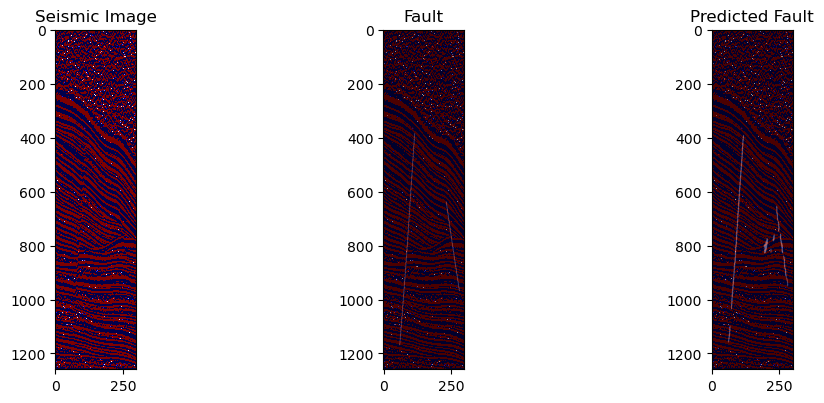

  2%|▏         | 67/2861 [08:07<7:44:31,  9.98s/it]

Epoch 3: Step 8650: U-Net loss: 0.3805239796638489


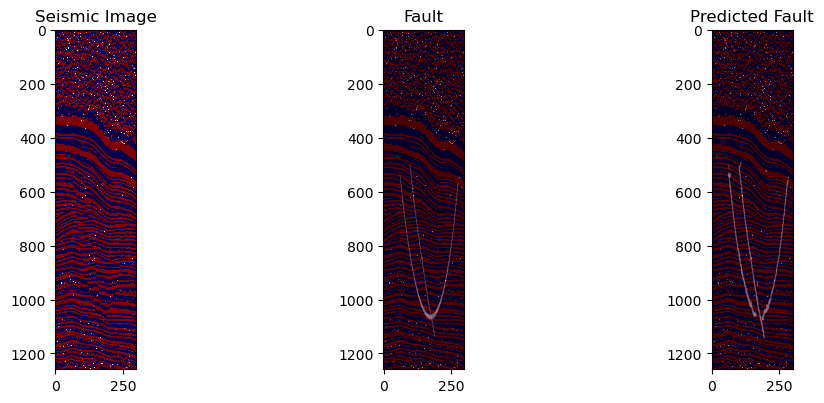

  4%|▍         | 117/2861 [13:25<3:53:52,  5.11s/it] 

Epoch 3: Step 8700: U-Net loss: 0.34389829635620117


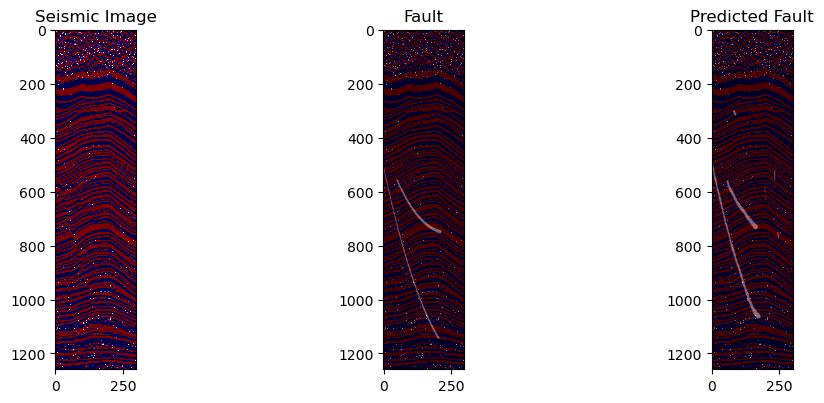

  6%|▌         | 167/2861 [17:48<3:29:24,  4.66s/it]

Epoch 3: Step 8750: U-Net loss: 0.2991679310798645


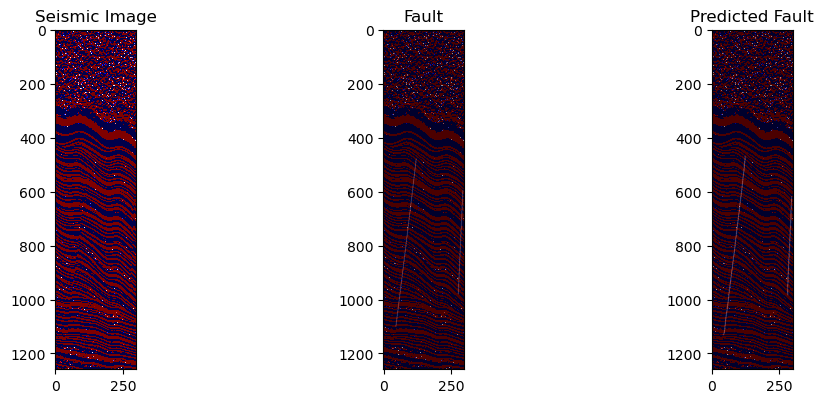

  8%|▊         | 217/2861 [22:07<3:11:57,  4.36s/it]

Epoch 3: Step 8800: U-Net loss: 0.43969476222991943


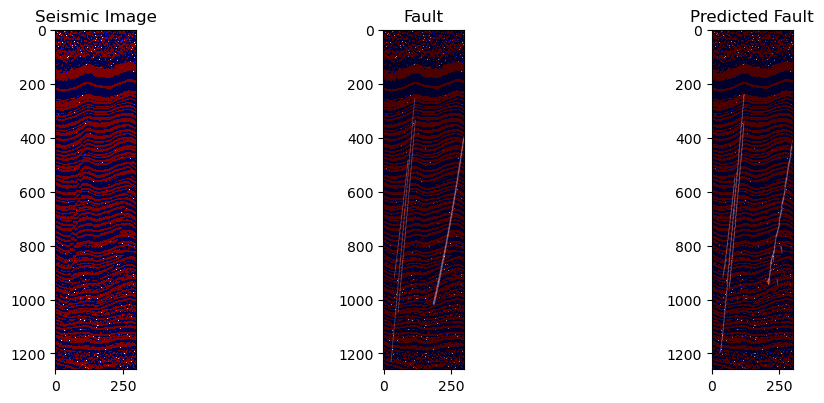

  9%|▉         | 267/2861 [27:28<3:54:10,  5.42s/it] 

Epoch 3: Step 8850: U-Net loss: 0.5793206095695496


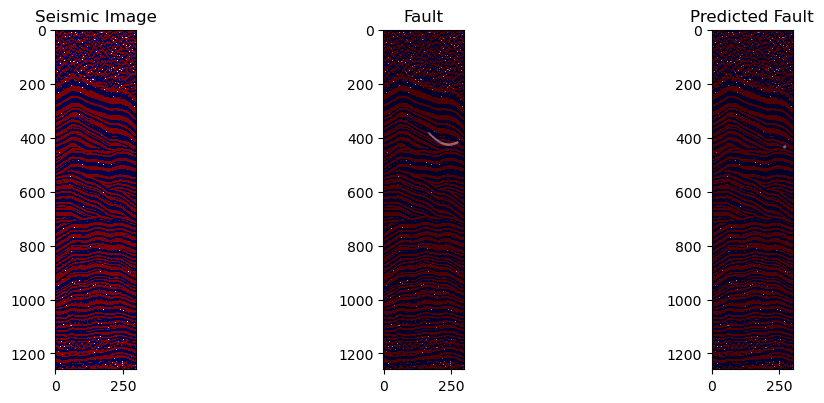

 11%|█         | 317/2861 [30:55<2:27:26,  3.48s/it]

Epoch 3: Step 8900: U-Net loss: 0.2847917079925537


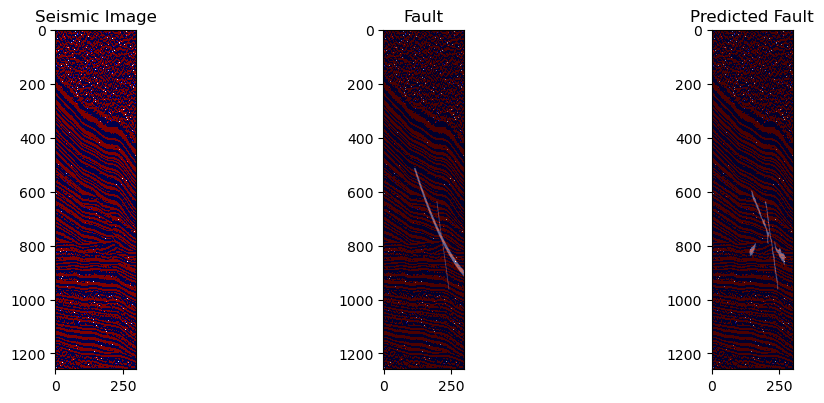

 13%|█▎        | 367/2861 [35:04<3:22:50,  4.88s/it]

Epoch 3: Step 8950: U-Net loss: 0.3243296146392822


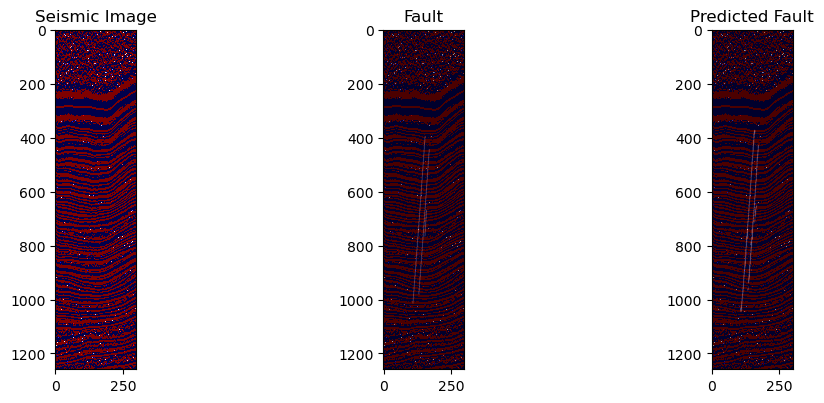

 15%|█▍        | 417/2861 [39:01<4:34:39,  6.74s/it]

Epoch 3: Step 9000: U-Net loss: 0.39386308193206787


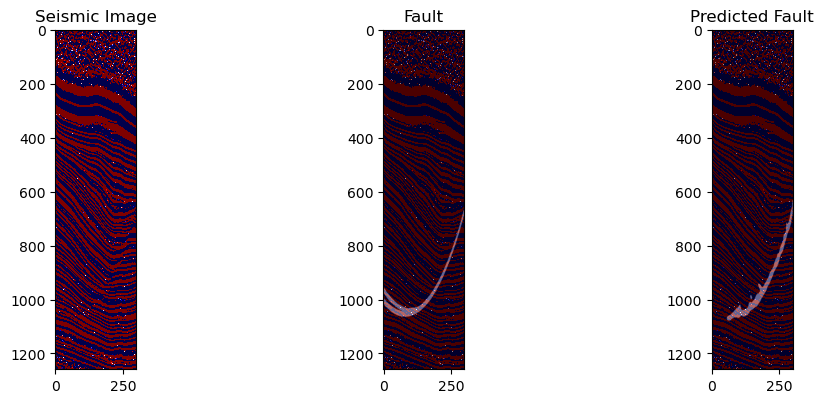

 16%|█▋        | 467/2861 [42:46<3:19:37,  5.00s/it]

Epoch 3: Step 9050: U-Net loss: 0.15611308813095093


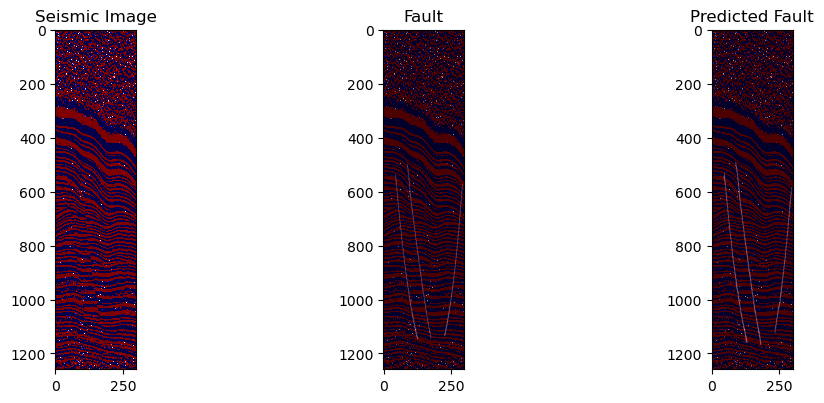

 18%|█▊        | 517/2861 [46:31<2:33:18,  3.92s/it]

Epoch 3: Step 9100: U-Net loss: 0.18176895380020142


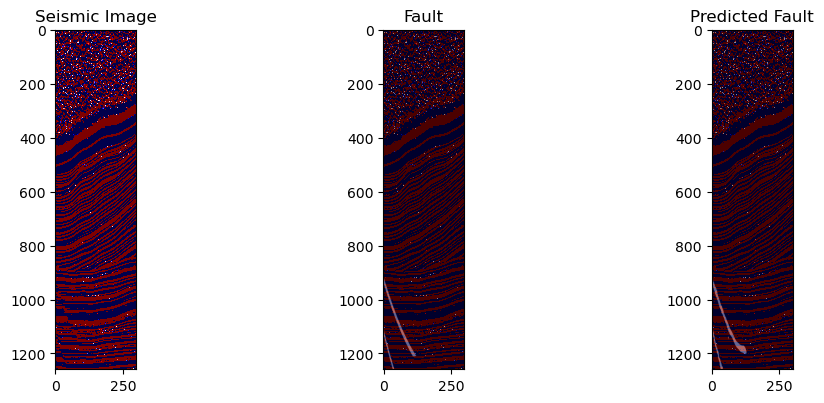

 20%|█▉        | 567/2861 [50:23<3:29:44,  5.49s/it]

Epoch 3: Step 9150: U-Net loss: 0.2756752371788025


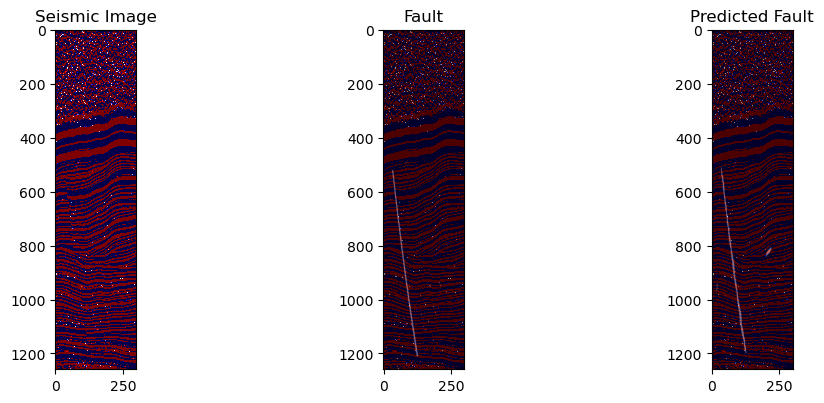

 22%|██▏       | 617/2861 [54:44<3:07:08,  5.00s/it]

Epoch 3: Step 9200: U-Net loss: 0.252737820148468


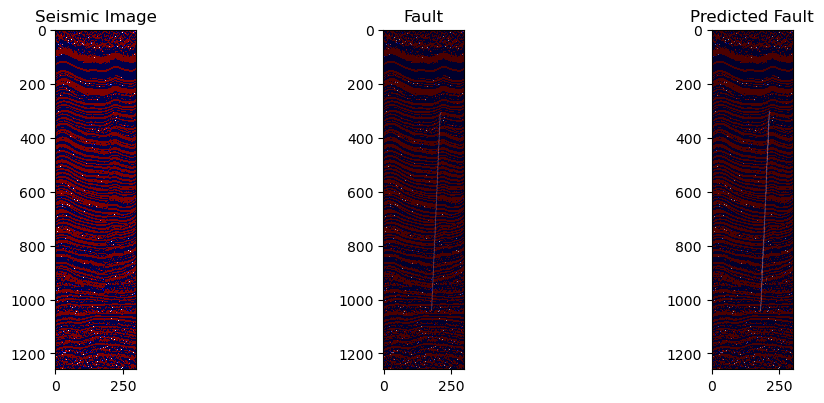

 23%|██▎       | 667/2861 [58:45<3:26:12,  5.64s/it]

Epoch 3: Step 9250: U-Net loss: 0.28828346729278564


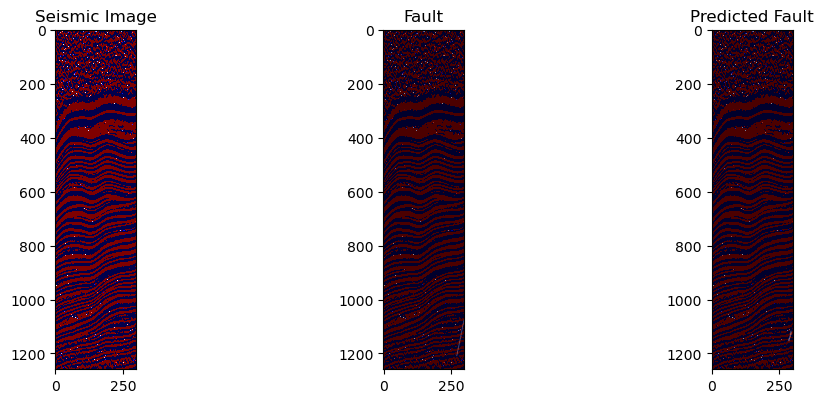

 25%|██▌       | 717/2861 [1:02:29<1:49:38,  3.07s/it]

Epoch 3: Step 9300: U-Net loss: 0.19609999656677246


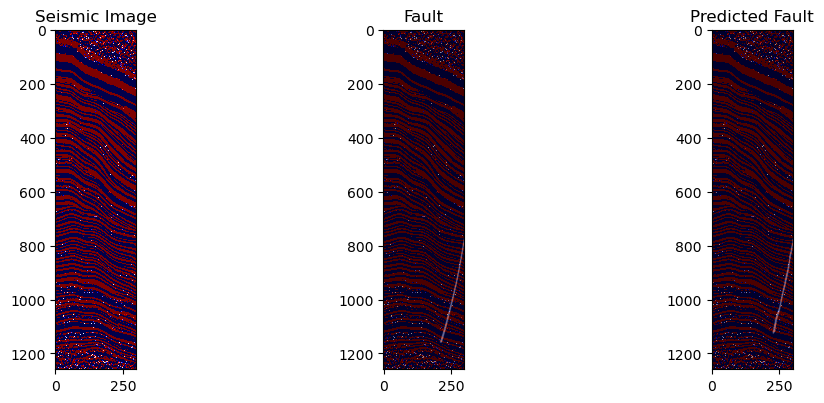

 27%|██▋       | 767/2861 [1:06:55<3:40:44,  6.32s/it]

Epoch 3: Step 9350: U-Net loss: 0.2910180687904358


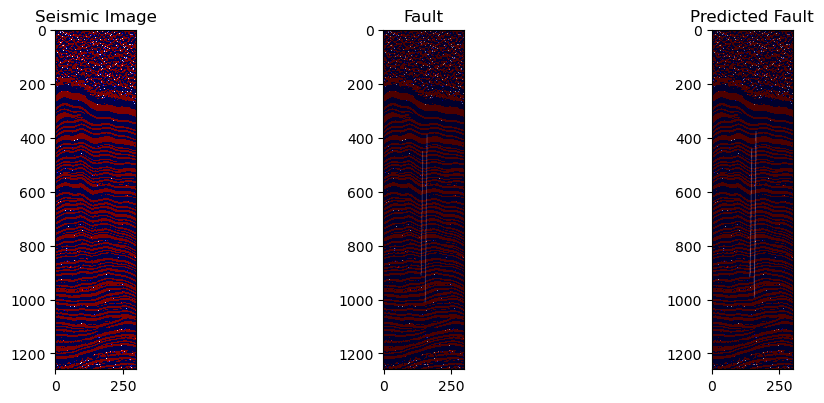

 29%|██▊       | 817/2861 [1:14:45<6:37:12, 11.66s/it]

Epoch 3: Step 9400: U-Net loss: 0.3226313591003418


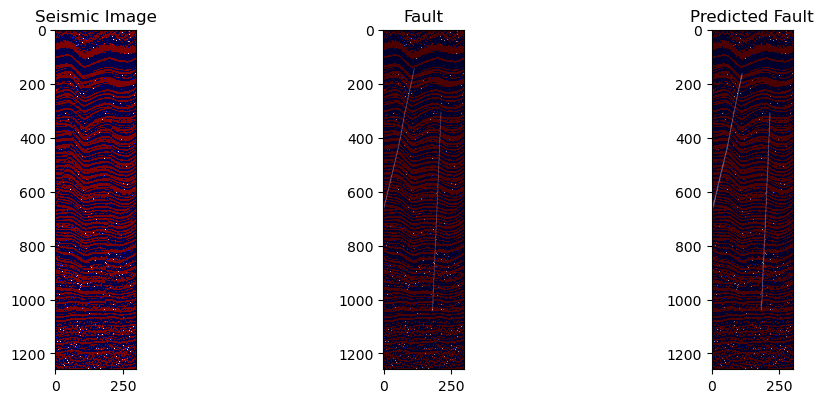

 30%|███       | 867/2861 [1:21:17<4:37:20,  8.35s/it]

Epoch 3: Step 9450: U-Net loss: 0.17850834131240845


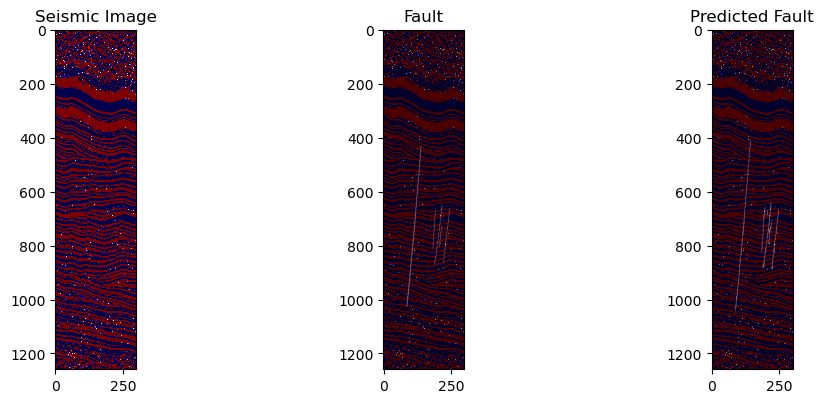

 32%|███▏      | 917/2861 [1:29:48<3:27:49,  6.41s/it] 

Epoch 3: Step 9500: U-Net loss: 0.28846287727355957


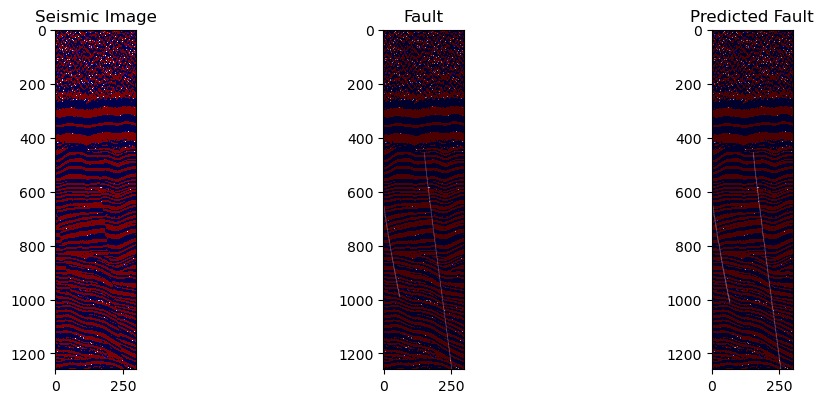

 34%|███▍      | 967/2861 [1:37:50<3:28:52,  6.62s/it] 

Epoch 3: Step 9550: U-Net loss: 0.28333306312561035


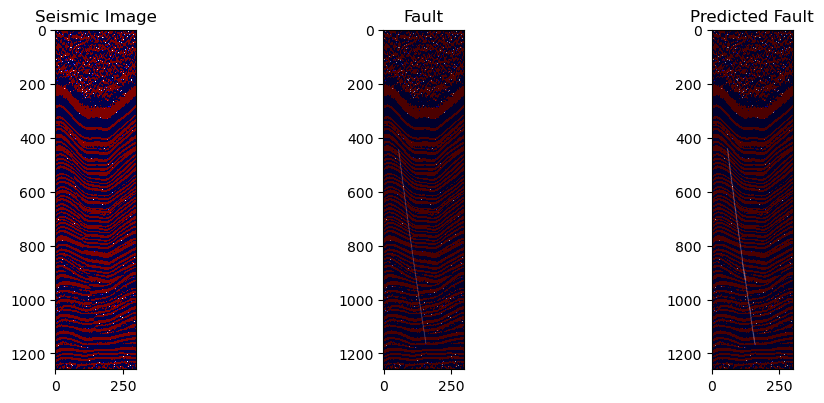

 36%|███▌      | 1017/2861 [1:45:12<3:21:31,  6.56s/it]

Epoch 3: Step 9600: U-Net loss: 0.19295024871826172


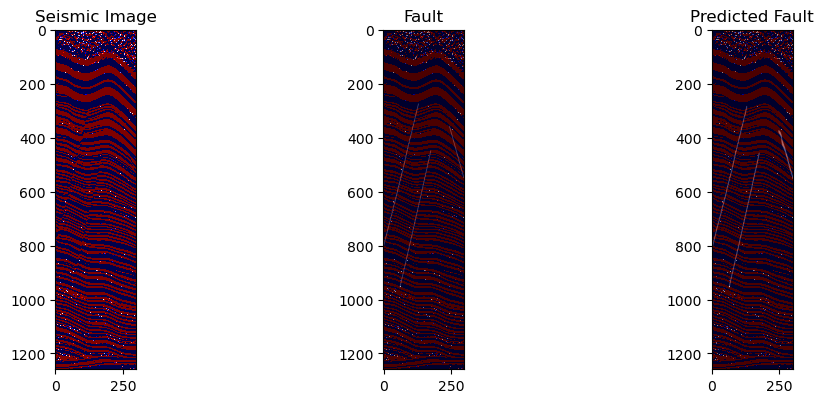

 37%|███▋      | 1067/2861 [1:53:12<3:23:30,  6.81s/it] 

Epoch 3: Step 9650: U-Net loss: 0.2097451090812683


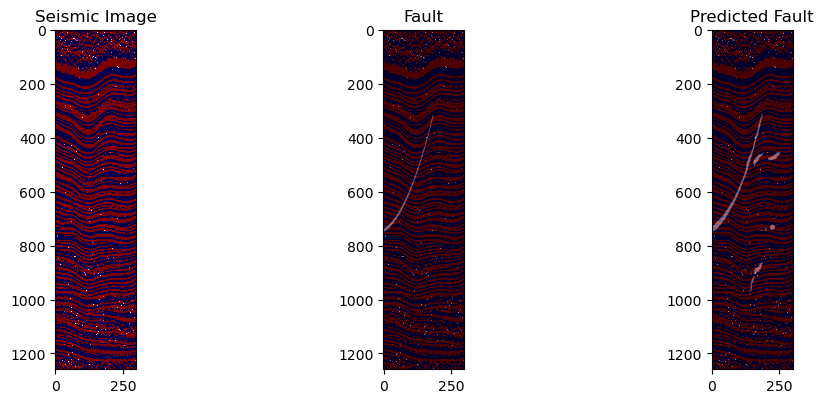

 39%|███▉      | 1117/2861 [1:57:52<2:41:15,  5.55s/it]

Epoch 3: Step 9700: U-Net loss: 0.22785282135009766


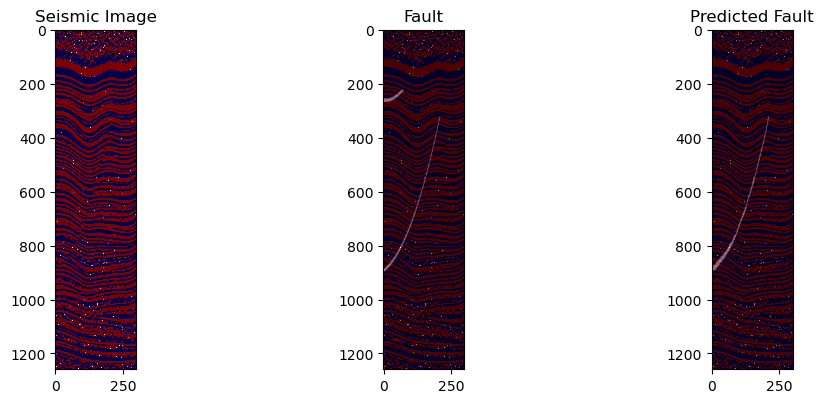

 41%|████      | 1167/2861 [2:02:20<2:24:03,  5.10s/it]

Epoch 3: Step 9750: U-Net loss: 0.22064918279647827


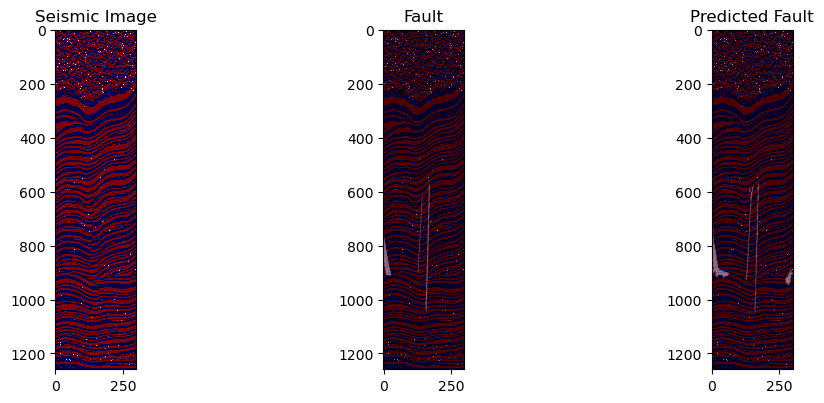

 43%|████▎     | 1217/2861 [2:05:59<1:45:03,  3.83s/it]

Epoch 3: Step 9800: U-Net loss: 0.15994256734848022


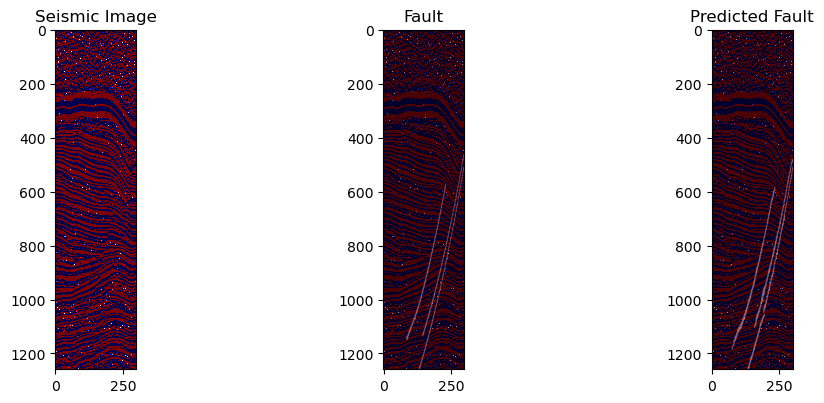

 44%|████▍     | 1267/2861 [2:09:22<1:41:25,  3.82s/it]

Epoch 3: Step 9850: U-Net loss: 0.45007914304733276


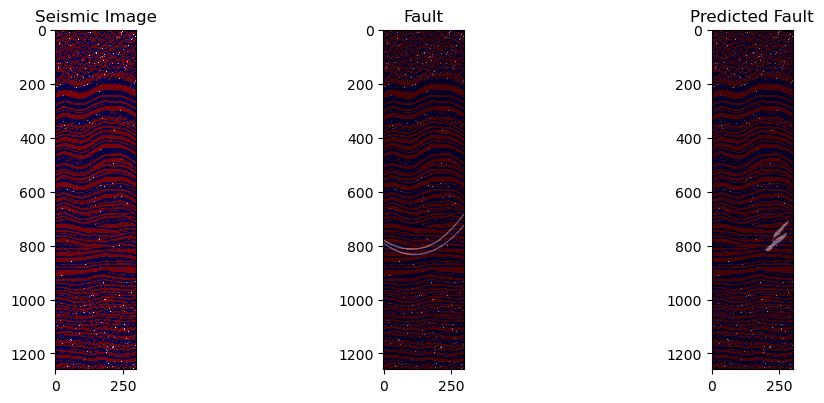

 46%|████▌     | 1317/2861 [2:13:01<2:02:39,  4.77s/it]

Epoch 3: Step 9900: U-Net loss: 0.18744701147079468


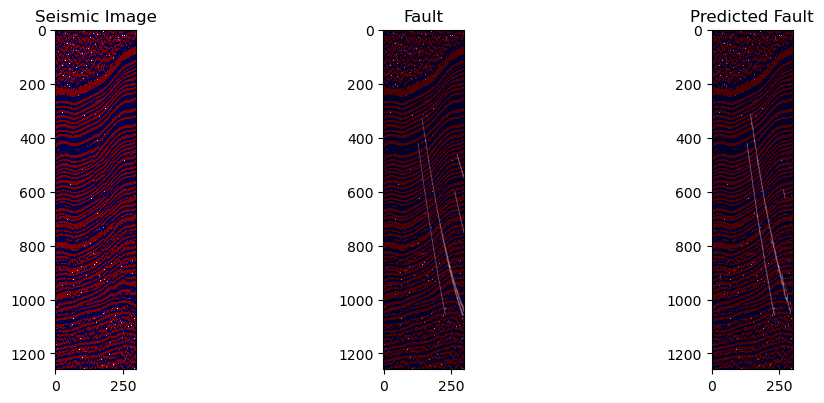

 48%|████▊     | 1367/2861 [2:16:36<1:23:11,  3.34s/it]

Epoch 3: Step 9950: U-Net loss: 0.18890172243118286


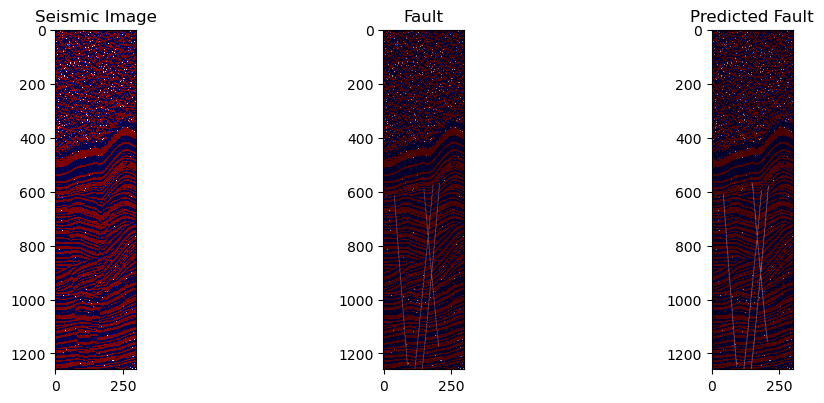

 50%|████▉     | 1417/2861 [2:20:29<1:53:30,  4.72s/it]

Epoch 3: Step 10000: U-Net loss: 0.2341558337211609


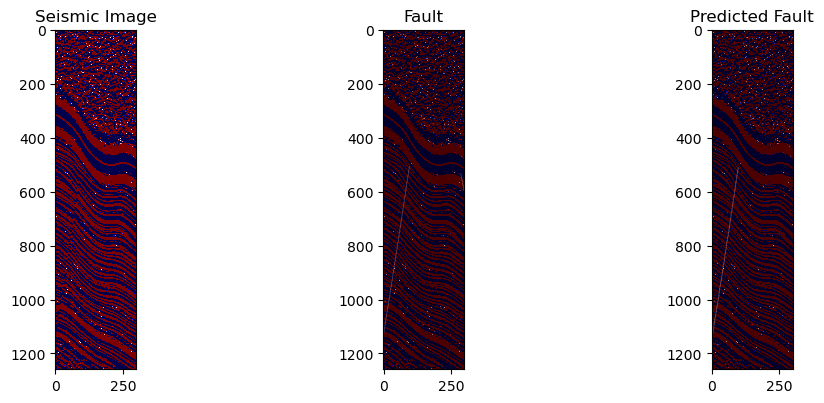

 51%|█████▏    | 1467/2861 [2:24:24<1:44:29,  4.50s/it]

Epoch 3: Step 10050: U-Net loss: 0.16286277770996094


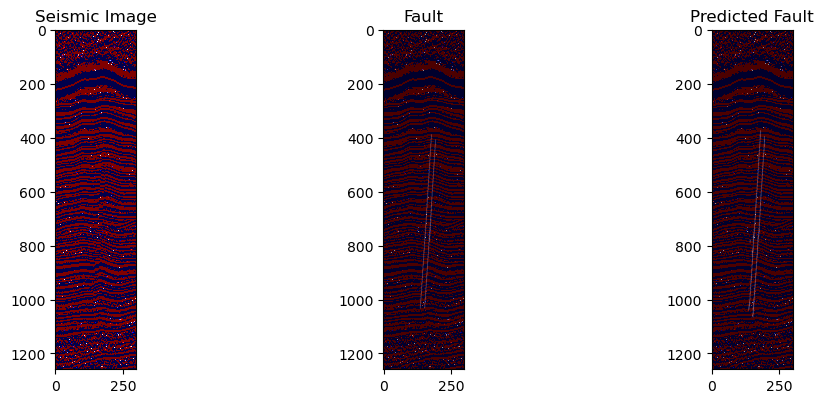

 53%|█████▎    | 1517/2861 [2:28:17<1:52:29,  5.02s/it]

Epoch 3: Step 10100: U-Net loss: 0.22167986631393433


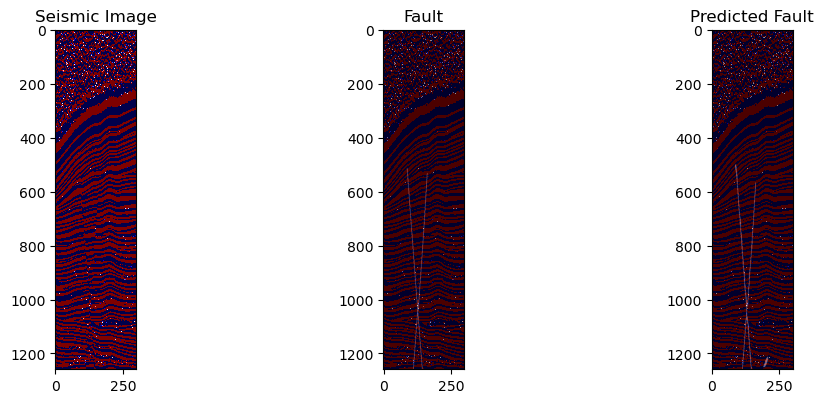

 55%|█████▍    | 1567/2861 [2:32:14<2:11:22,  6.09s/it]

Epoch 3: Step 10150: U-Net loss: 0.18020278215408325


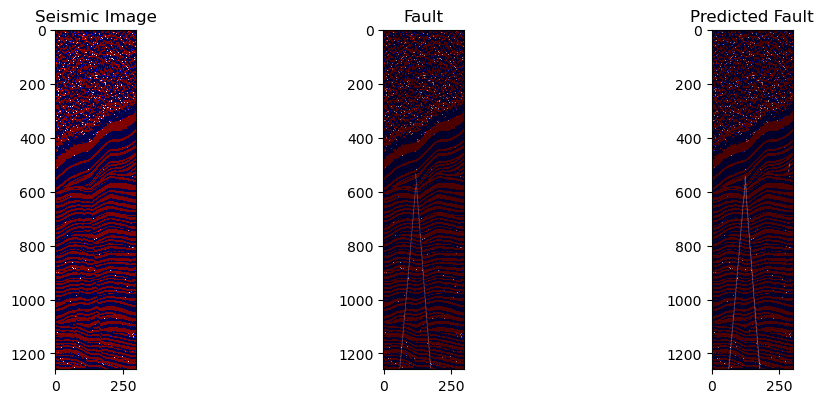

 57%|█████▋    | 1617/2861 [2:35:42<1:21:13,  3.92s/it]

Epoch 3: Step 10200: U-Net loss: 0.17910349369049072


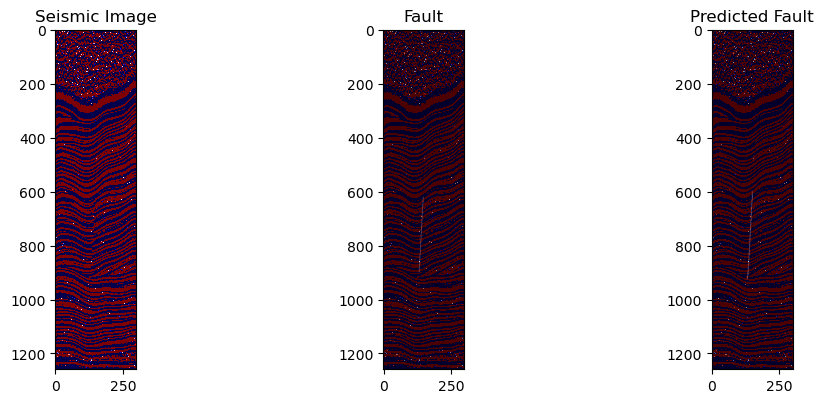

 58%|█████▊    | 1667/2861 [2:39:16<1:06:57,  3.36s/it]

Epoch 3: Step 10250: U-Net loss: 0.31460970640182495


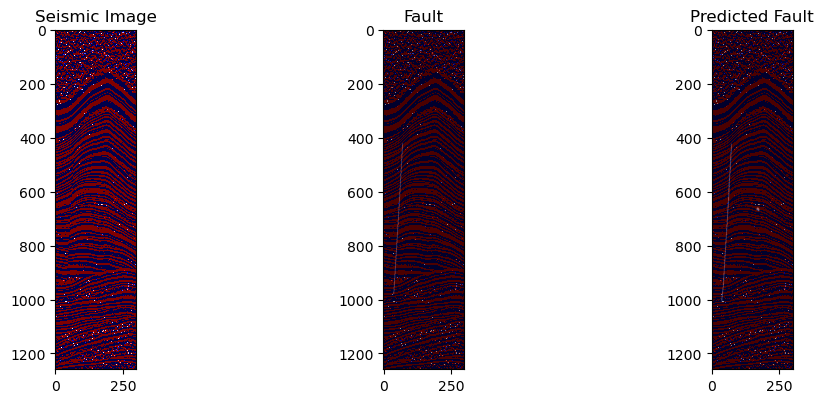

 60%|██████    | 1717/2861 [2:42:47<1:28:07,  4.62s/it]

Epoch 3: Step 10300: U-Net loss: 0.2484602928161621


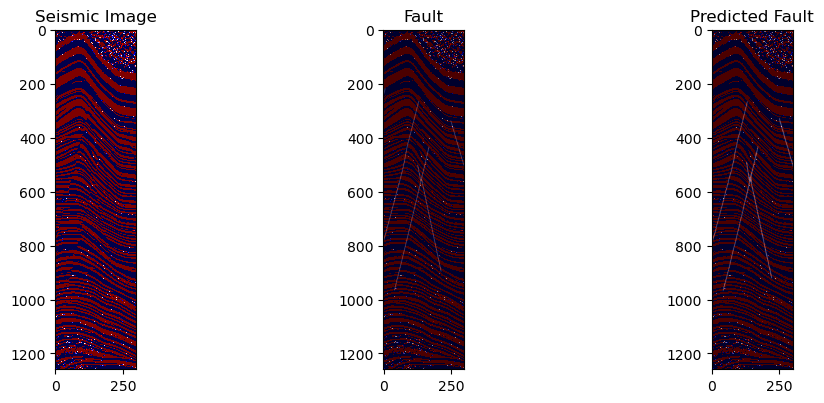

 62%|██████▏   | 1767/2861 [2:46:27<1:24:42,  4.65s/it]

Epoch 3: Step 10350: U-Net loss: 0.17808890342712402


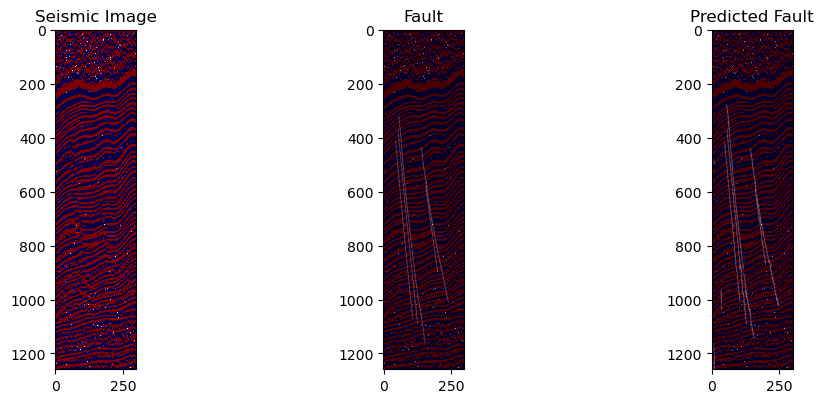

 64%|██████▎   | 1817/2861 [2:50:01<1:20:34,  4.63s/it]

Epoch 3: Step 10400: U-Net loss: 0.3128660321235657


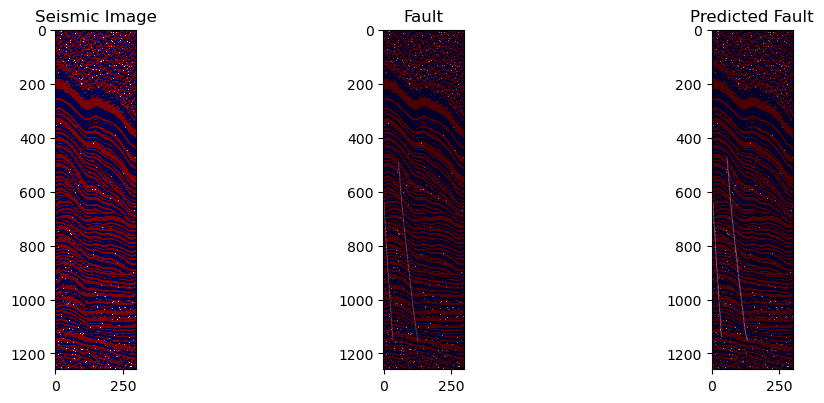

 65%|██████▌   | 1867/2861 [2:53:58<1:07:14,  4.06s/it]

Epoch 3: Step 10450: U-Net loss: 0.16934412717819214


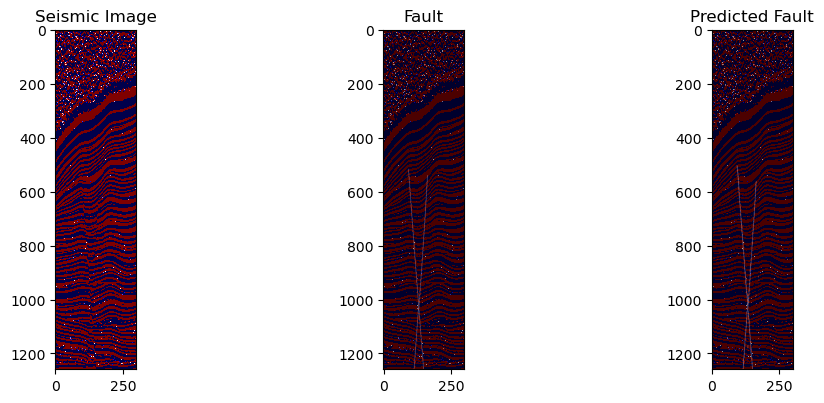

 67%|██████▋   | 1917/2861 [2:57:40<1:20:12,  5.10s/it]

Epoch 3: Step 10500: U-Net loss: 0.12994521856307983


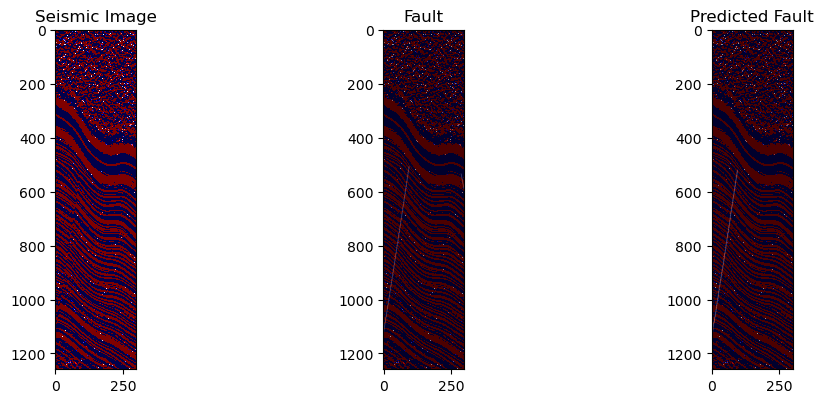

 69%|██████▉   | 1967/2861 [3:01:36<1:07:28,  4.53s/it]

Epoch 3: Step 10550: U-Net loss: 0.14789187908172607


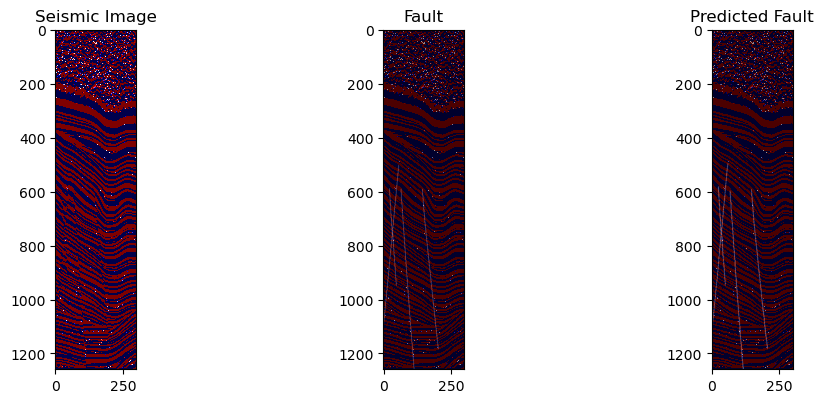

 70%|███████   | 2017/2861 [3:05:16<55:53,  3.97s/it]  

Epoch 3: Step 10600: U-Net loss: 0.16239458322525024


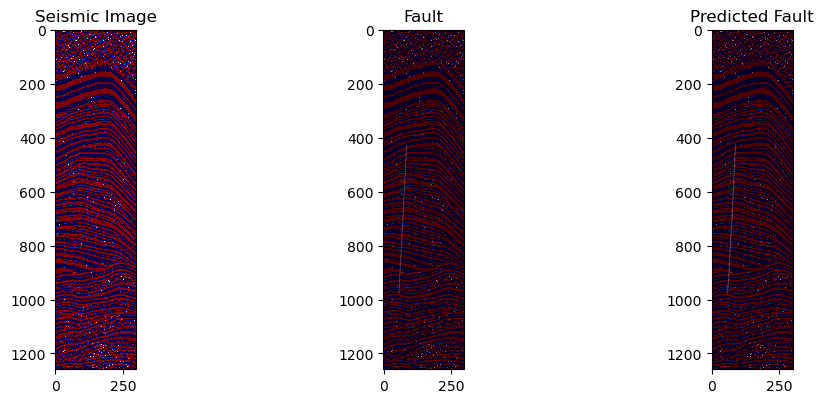

 72%|███████▏  | 2067/2861 [3:09:04<1:06:03,  4.99s/it]

Epoch 3: Step 10650: U-Net loss: 0.37045520544052124


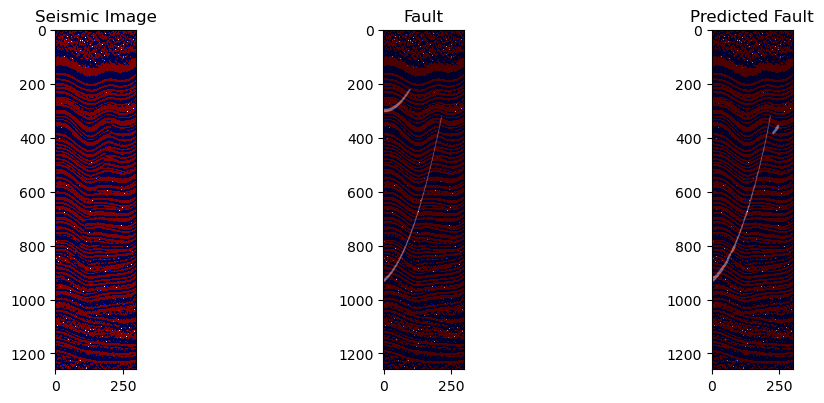

 74%|███████▍  | 2117/2861 [3:13:01<1:00:27,  4.88s/it]

Epoch 3: Step 10700: U-Net loss: 0.09616738557815552


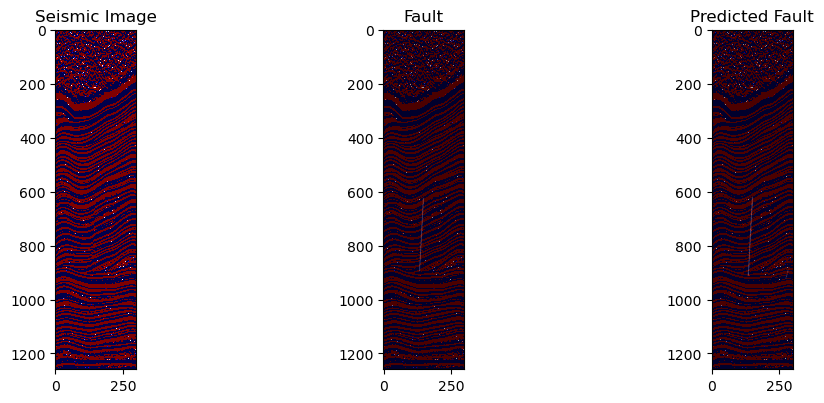

 76%|███████▌  | 2167/2861 [3:17:14<52:32,  4.54s/it]  

Epoch 3: Step 10750: U-Net loss: 0.17583906650543213


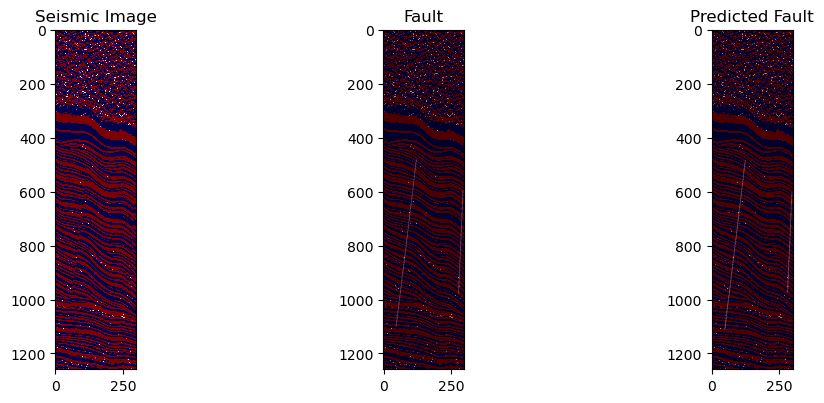

 77%|███████▋  | 2217/2861 [3:21:19<53:56,  5.03s/it]  

Epoch 3: Step 10800: U-Net loss: 0.17725342512130737


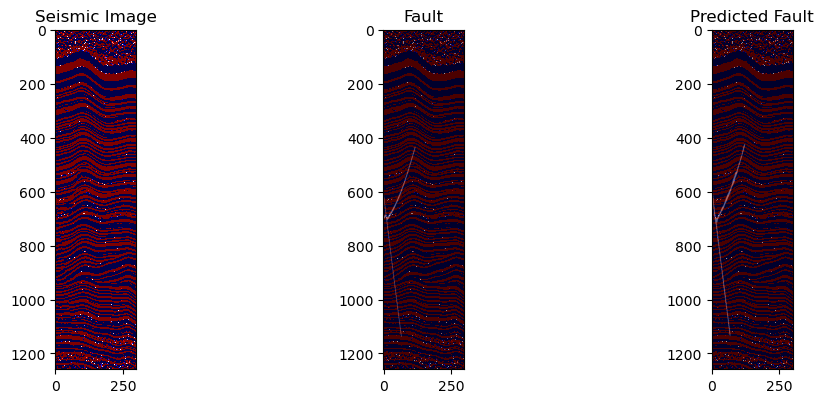

 79%|███████▉  | 2267/2861 [3:25:07<44:10,  4.46s/it]  

Epoch 3: Step 10850: U-Net loss: 0.4032568335533142


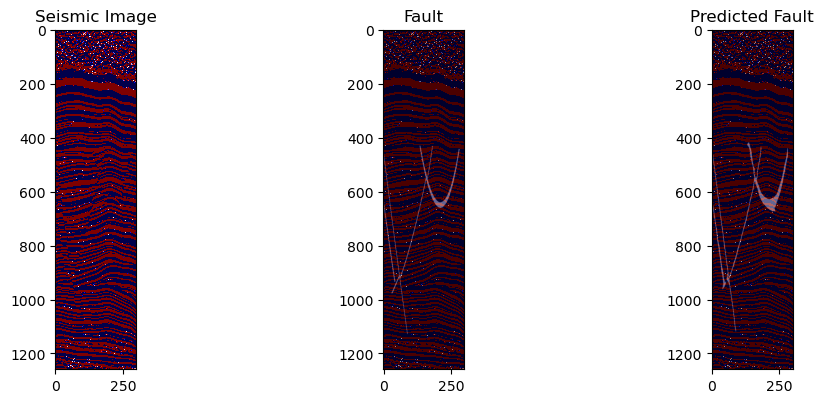

 81%|████████  | 2317/2861 [3:28:52<41:49,  4.61s/it]  

Epoch 3: Step 10900: U-Net loss: 0.16604024171829224


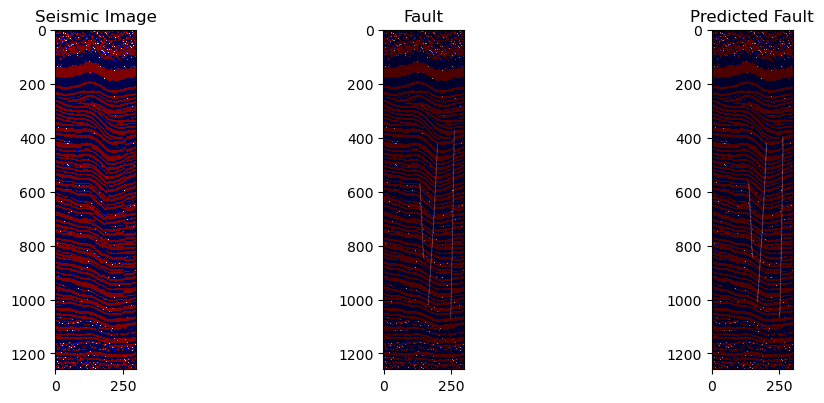

 83%|████████▎ | 2367/2861 [3:32:45<31:33,  3.83s/it]

Epoch 3: Step 10950: U-Net loss: 0.20039236545562744


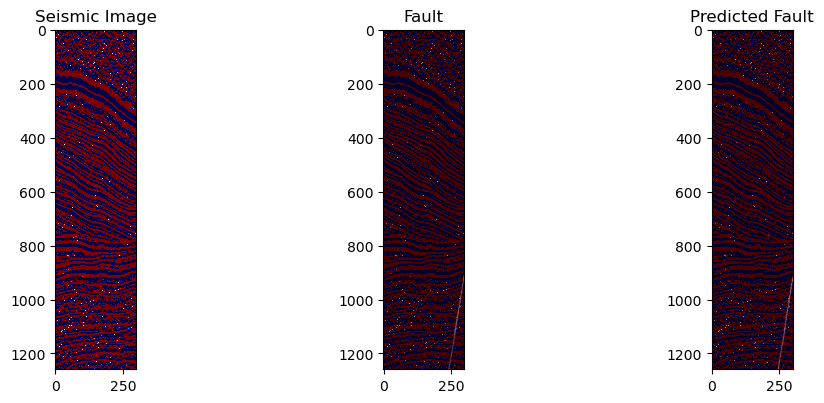

 84%|████████▍ | 2417/2861 [3:36:40<31:21,  4.24s/it]

Epoch 3: Step 11000: U-Net loss: 0.21374964714050293


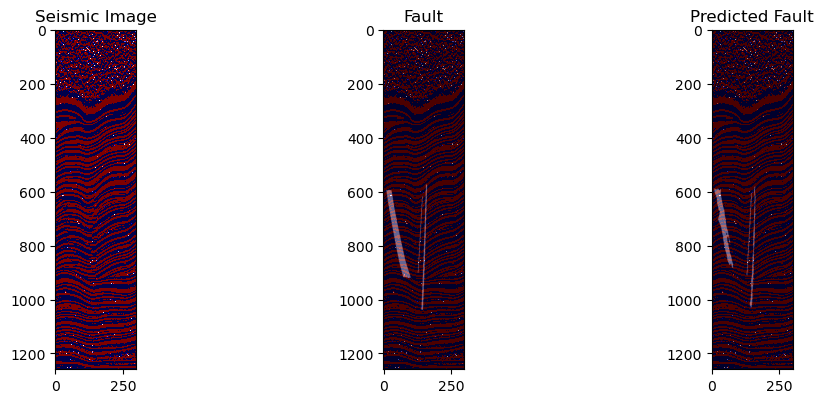

 86%|████████▌ | 2467/2861 [3:40:30<26:28,  4.03s/it]

Epoch 3: Step 11050: U-Net loss: 0.34414494037628174


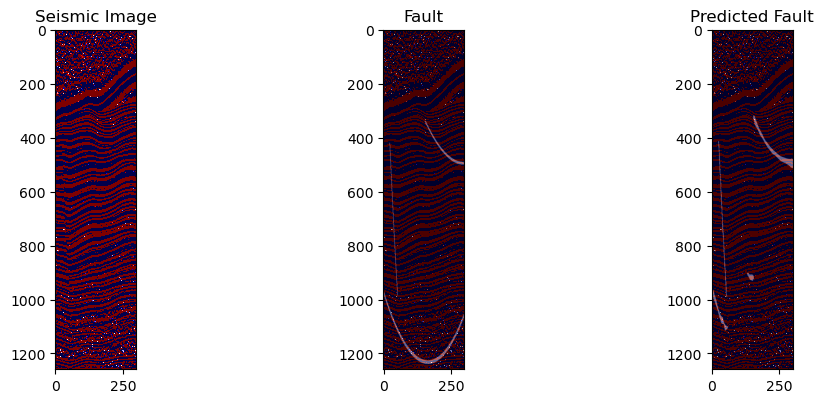

 88%|████████▊ | 2517/2861 [3:44:18<28:33,  4.98s/it]

Epoch 3: Step 11100: U-Net loss: 0.19399791955947876


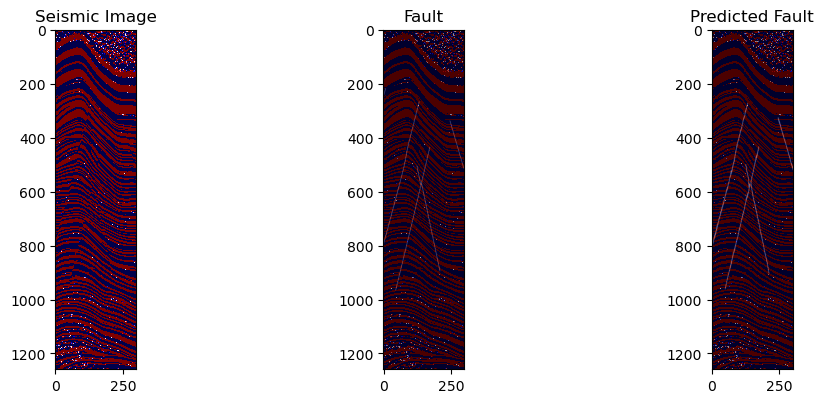

 90%|████████▉ | 2567/2861 [3:48:09<22:26,  4.58s/it]

Epoch 3: Step 11150: U-Net loss: 0.2969544529914856


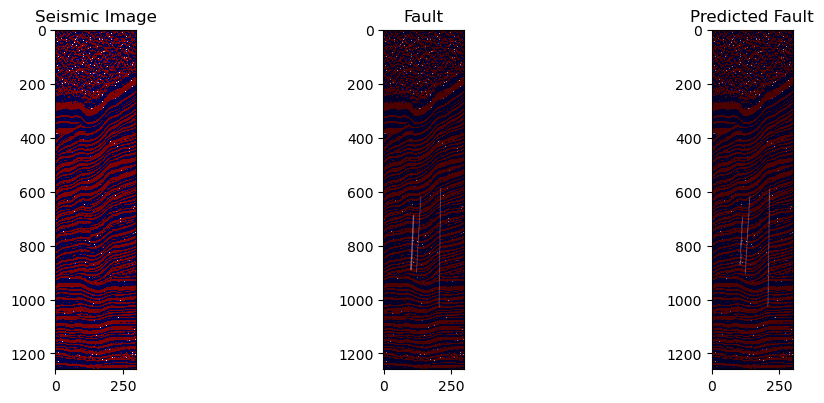

 91%|█████████▏| 2617/2861 [3:53:04<19:31,  4.80s/it]

Epoch 3: Step 11200: U-Net loss: 0.15096557140350342


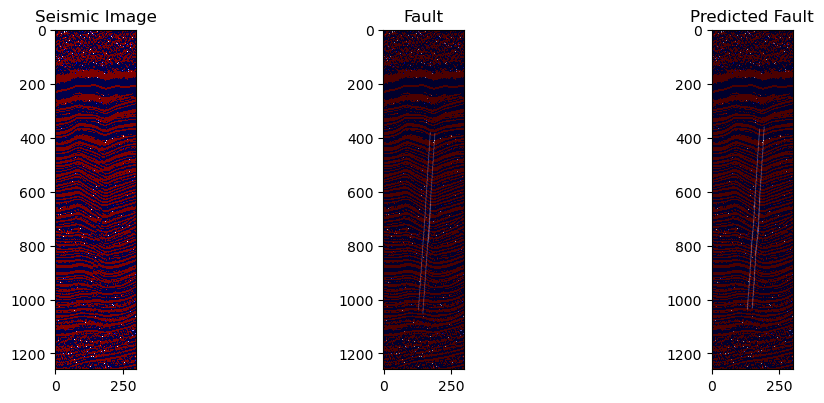

 93%|█████████▎| 2667/2861 [3:57:17<14:00,  4.33s/it]

Epoch 3: Step 11250: U-Net loss: 0.2417302131652832


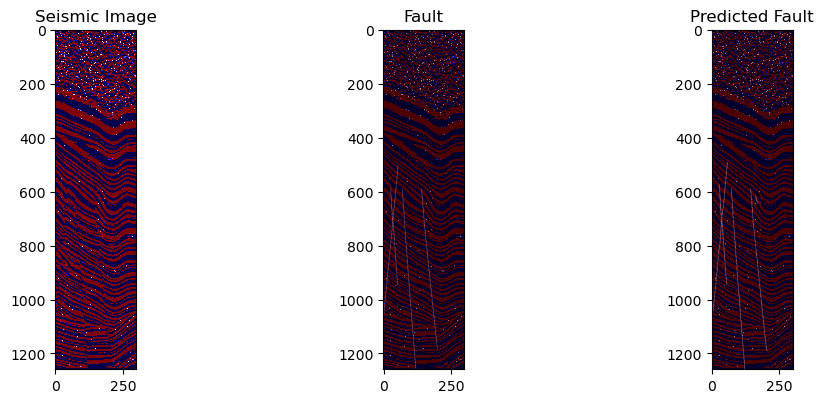

 95%|█████████▍| 2717/2861 [4:00:57<10:07,  4.22s/it]

Epoch 3: Step 11300: U-Net loss: 0.1399773359298706


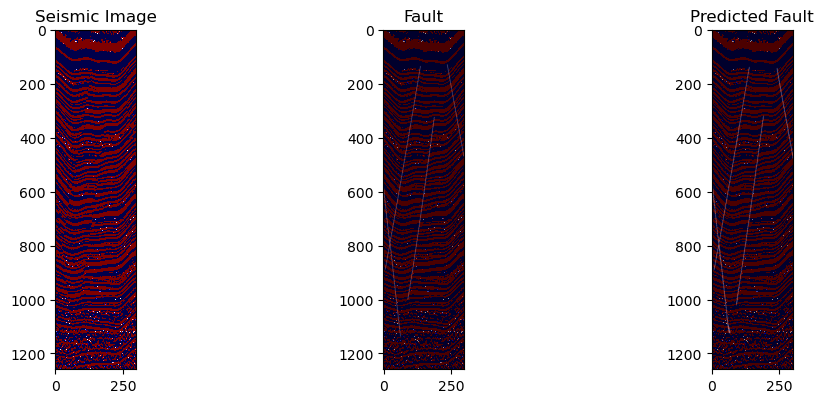

 97%|█████████▋| 2767/2861 [4:04:42<06:43,  4.30s/it]

Epoch 3: Step 11350: U-Net loss: 0.20238012075424194


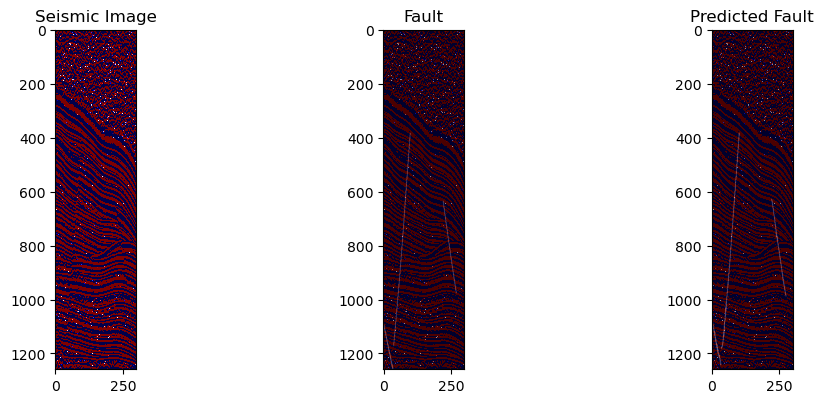

 98%|█████████▊| 2817/2861 [4:08:59<03:36,  4.91s/it]

Epoch 3: Step 11400: U-Net loss: 0.16971111297607422


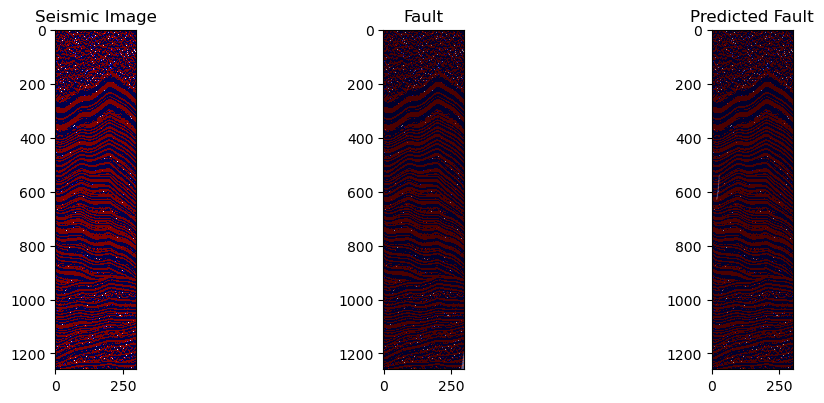

100%|██████████| 2861/2861 [4:13:29<00:00,  5.32s/it]


Checkpoint saved at epoch 4 to ///tmp/work/yutung/model_saved/unet_epoch_4.pth


  0%|          | 6/2861 [00:39<5:04:48,  6.41s/it]

Epoch 4: Step 11450: U-Net loss: 0.3217586874961853


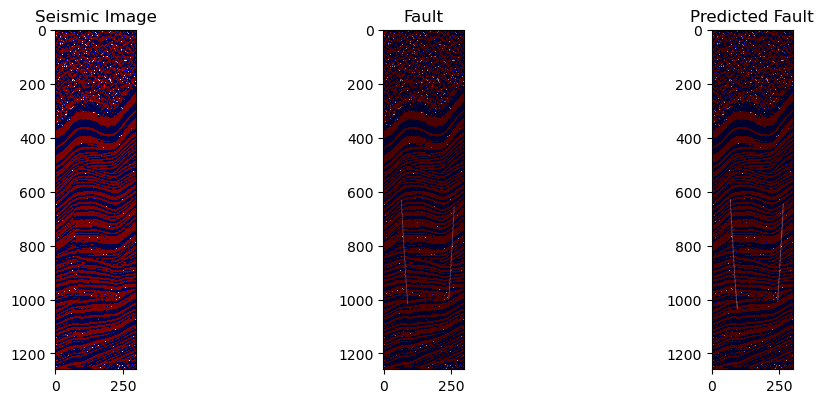

  2%|▏         | 56/2861 [05:17<4:19:44,  5.56s/it]

Epoch 4: Step 11500: U-Net loss: 0.1818908452987671


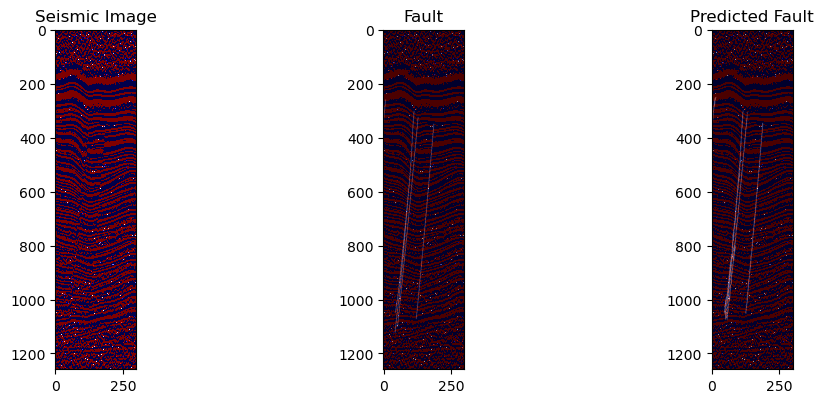

  4%|▎         | 106/2861 [09:27<3:38:17,  4.75s/it]

Epoch 4: Step 11550: U-Net loss: 0.1358393430709839


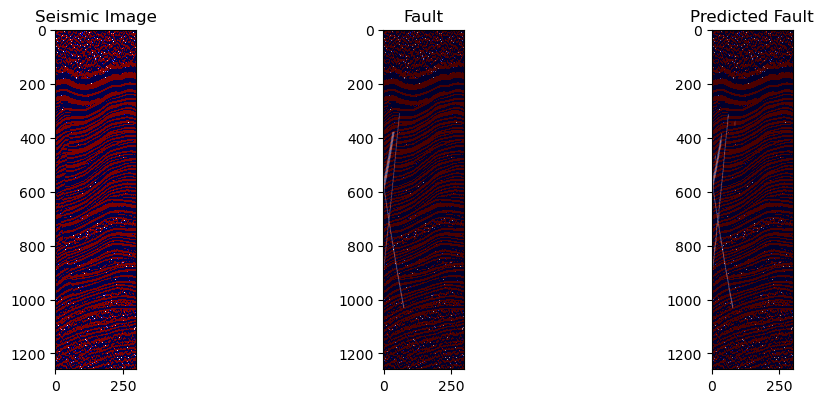

  5%|▌         | 156/2861 [13:27<4:21:05,  5.79s/it]

Epoch 4: Step 11600: U-Net loss: 0.26853376626968384


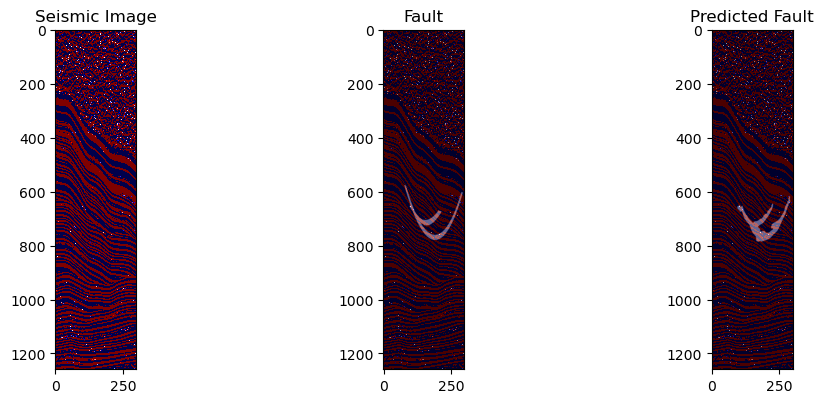

  7%|▋         | 206/2861 [19:44<4:04:48,  5.53s/it] 

Epoch 4: Step 11650: U-Net loss: 0.18304991722106934


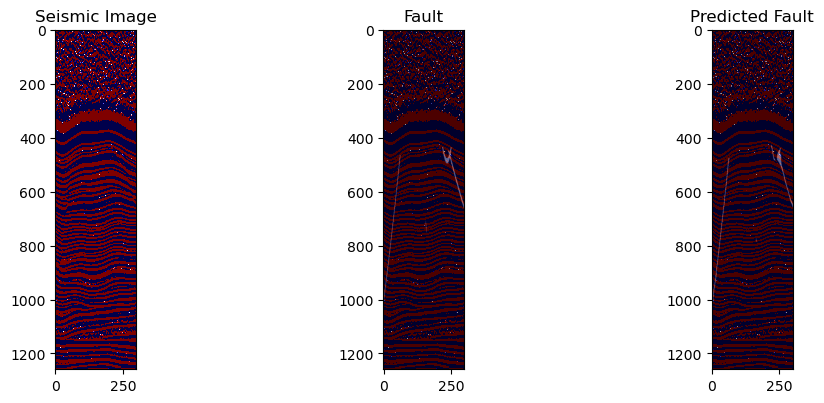

  9%|▉         | 256/2861 [23:10<2:47:23,  3.86s/it]

Epoch 4: Step 11700: U-Net loss: 0.21563494205474854


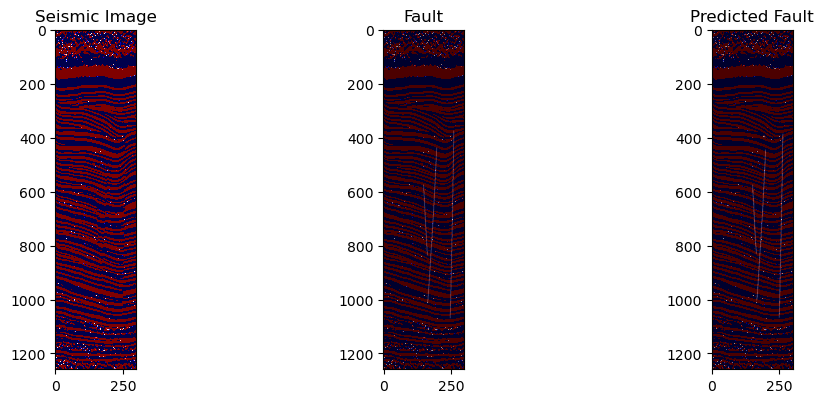

 11%|█         | 306/2861 [26:43<3:01:32,  4.26s/it]

Epoch 4: Step 11750: U-Net loss: 0.18743377923965454


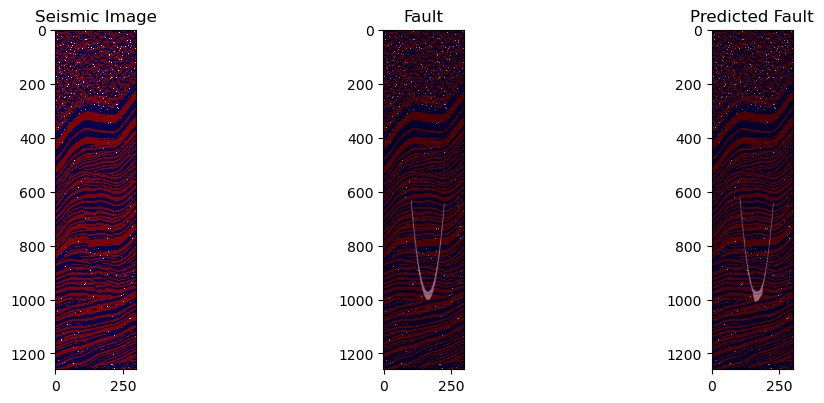

 12%|█▏        | 356/2861 [30:28<3:35:33,  5.16s/it]

Epoch 4: Step 11800: U-Net loss: 0.24883830547332764


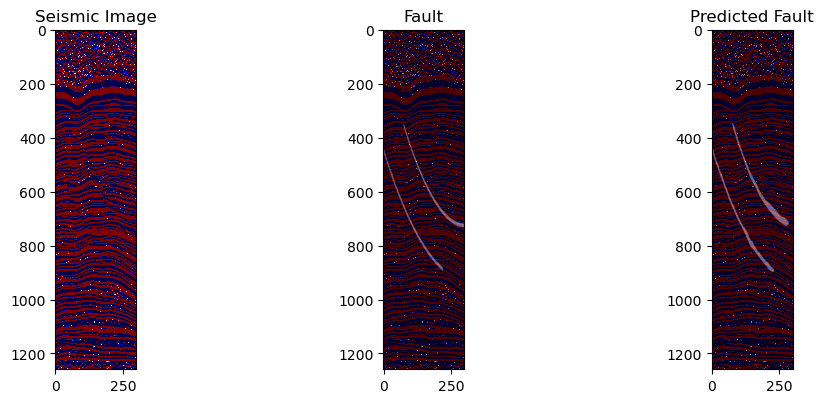

 14%|█▍        | 406/2861 [34:02<2:19:58,  3.42s/it]

Epoch 4: Step 11850: U-Net loss: 0.1821284294128418


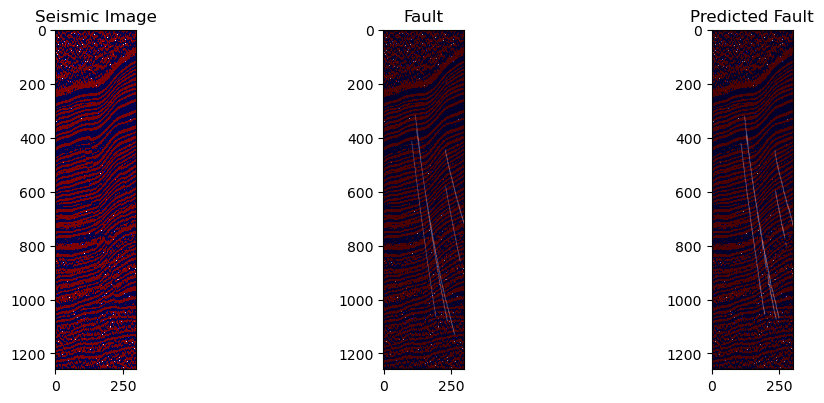

 16%|█▌        | 456/2861 [37:39<2:29:33,  3.73s/it]

Epoch 4: Step 11900: U-Net loss: 0.22661536931991577


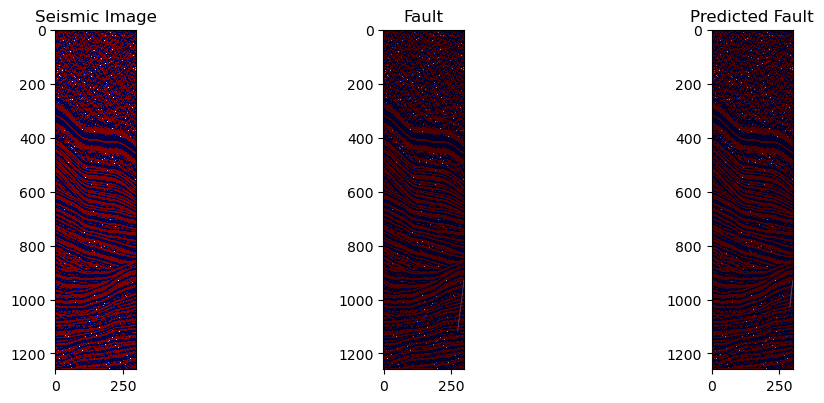

 18%|█▊        | 506/2861 [41:24<2:42:08,  4.13s/it]

Epoch 4: Step 11950: U-Net loss: 0.2291187047958374


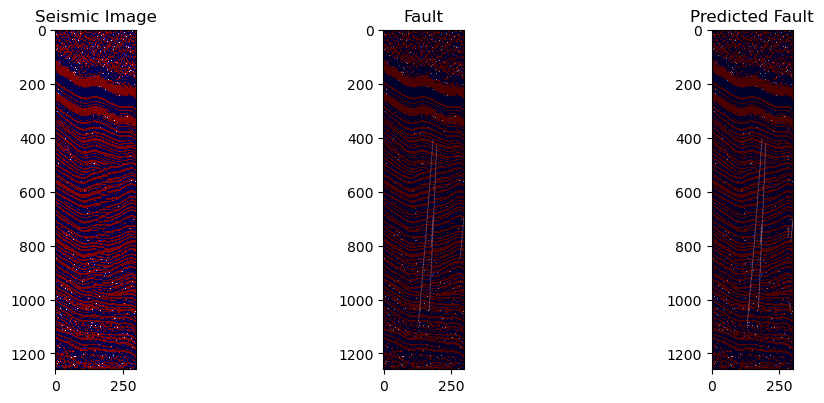

 19%|█▉        | 556/2861 [45:12<3:07:37,  4.88s/it]

Epoch 4: Step 12000: U-Net loss: 0.3497951626777649


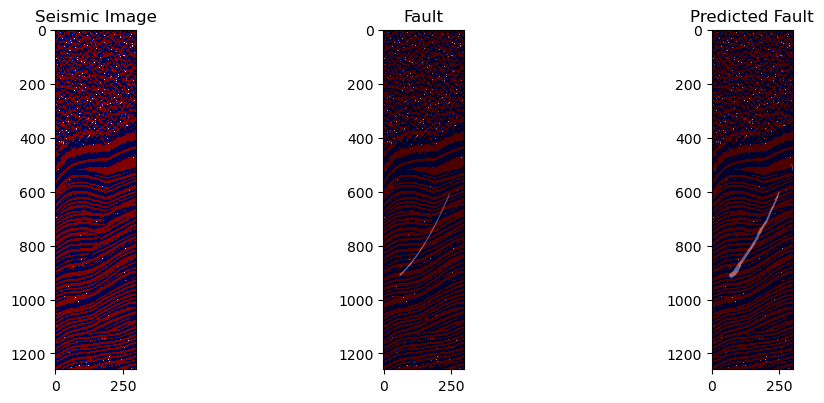

 21%|██        | 606/2861 [49:03<2:36:06,  4.15s/it]

Epoch 4: Step 12050: U-Net loss: 0.15780377388000488


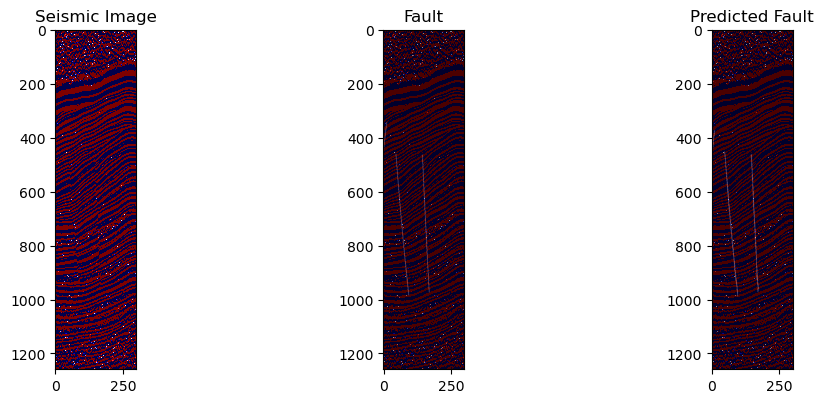

 23%|██▎       | 656/2861 [52:46<2:59:52,  4.89s/it]

Epoch 4: Step 12100: U-Net loss: 0.11536741256713867


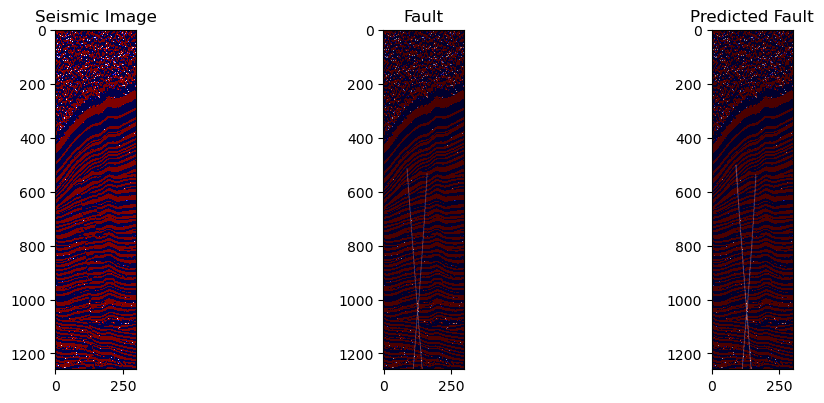

 25%|██▍       | 706/2861 [58:04<3:07:45,  5.23s/it]

Epoch 4: Step 12150: U-Net loss: 0.17960089445114136


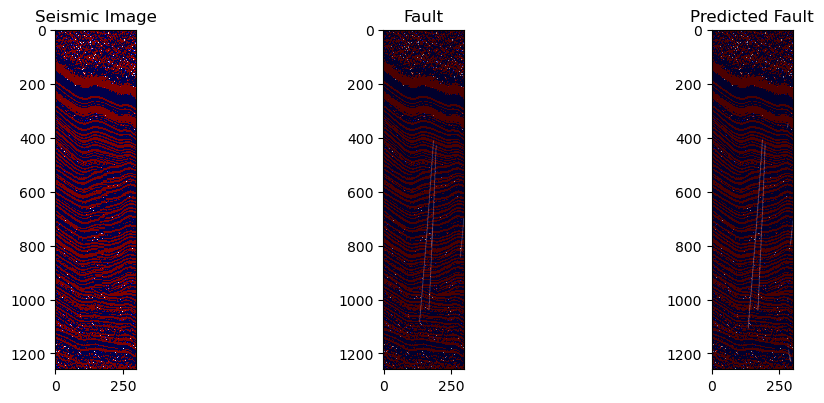

 26%|██▋       | 756/2861 [1:03:32<3:29:31,  5.97s/it]

Epoch 4: Step 12200: U-Net loss: 0.21625304222106934


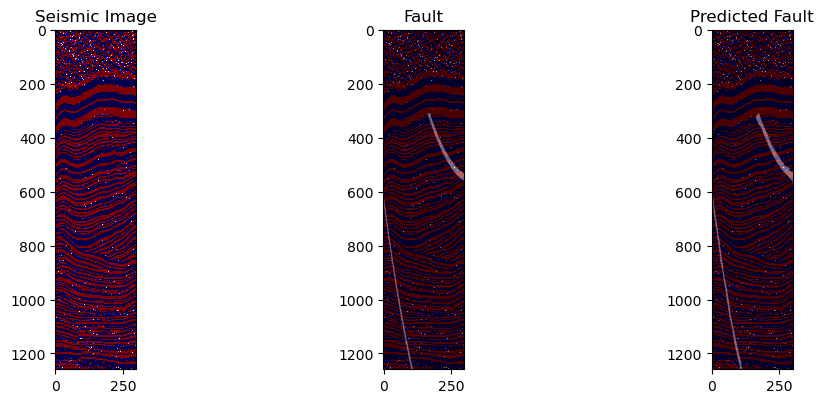

 28%|██▊       | 806/2861 [1:09:14<3:05:25,  5.41s/it]

Epoch 4: Step 12250: U-Net loss: 0.12233006954193115


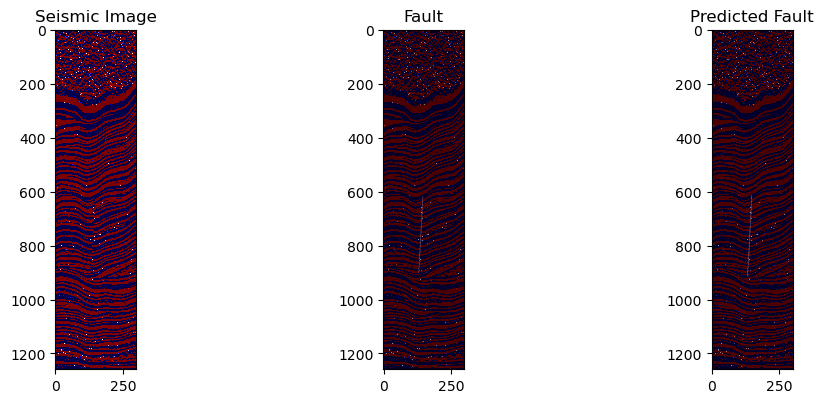

 30%|██▉       | 856/2861 [1:14:38<2:52:25,  5.16s/it]

Epoch 4: Step 12300: U-Net loss: 0.3278154134750366


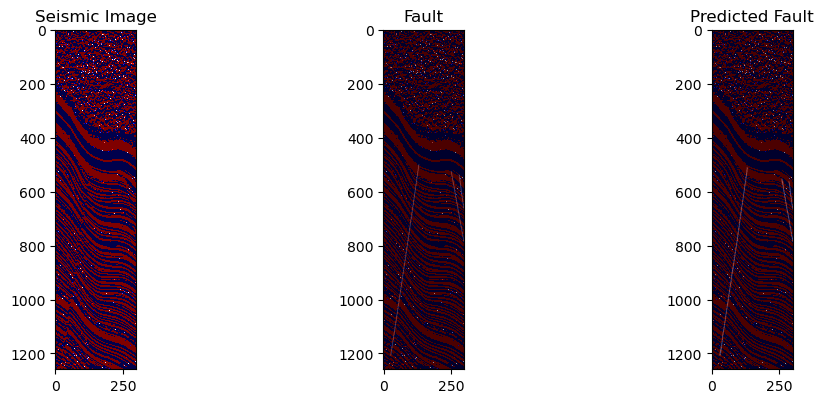

 32%|███▏      | 906/2861 [1:20:37<5:12:11,  9.58s/it]

Epoch 4: Step 12350: U-Net loss: 0.15055924654006958


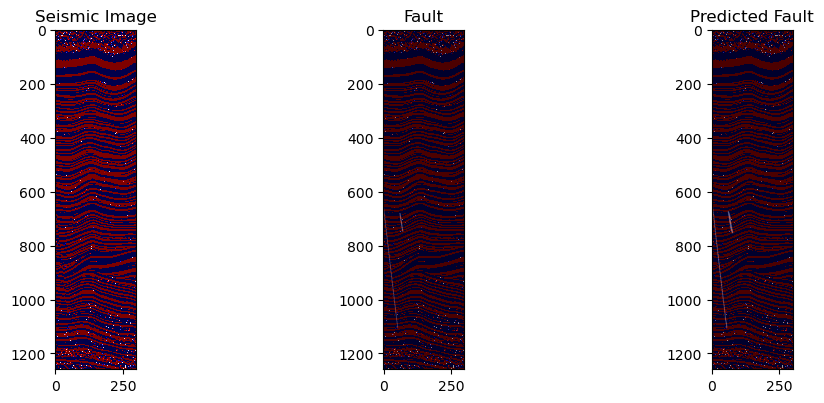

 33%|███▎      | 956/2861 [1:26:23<3:43:11,  7.03s/it]

Epoch 4: Step 12400: U-Net loss: 0.4116433262825012


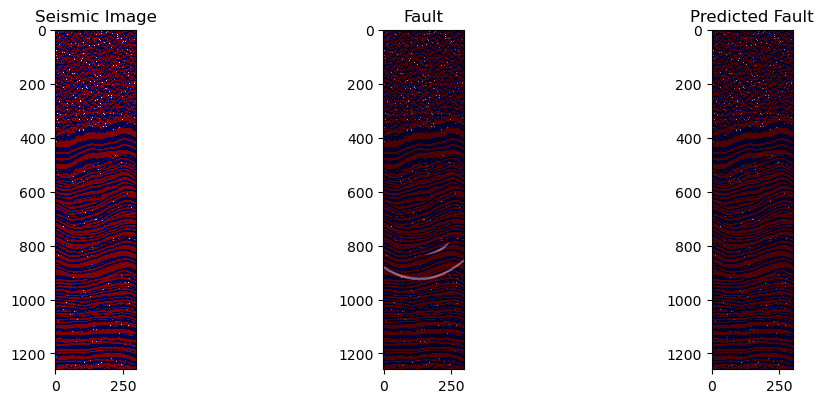

 35%|███▌      | 1006/2861 [1:31:34<2:16:31,  4.42s/it]

Epoch 4: Step 12450: U-Net loss: 0.17118382453918457


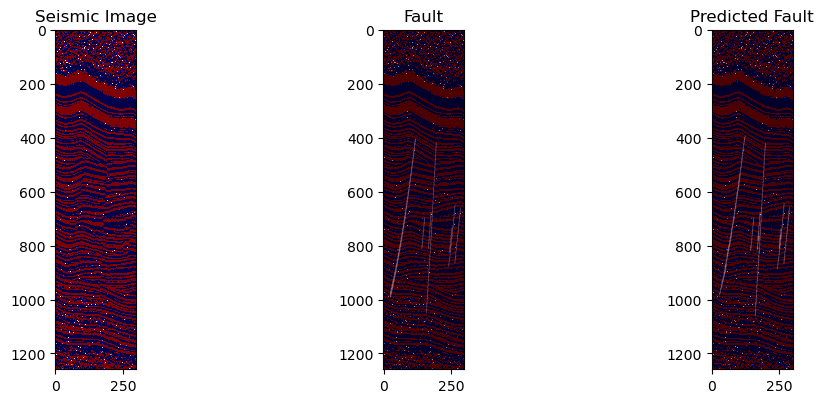

 37%|███▋      | 1056/2861 [1:36:59<2:47:37,  5.57s/it]

Epoch 4: Step 12500: U-Net loss: 0.16069084405899048


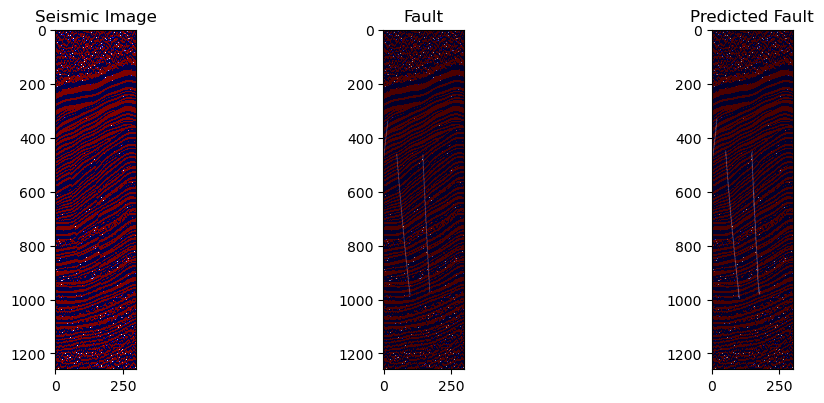

 39%|███▊      | 1106/2861 [1:41:05<2:13:45,  4.57s/it]

Epoch 4: Step 12550: U-Net loss: 0.18612700700759888


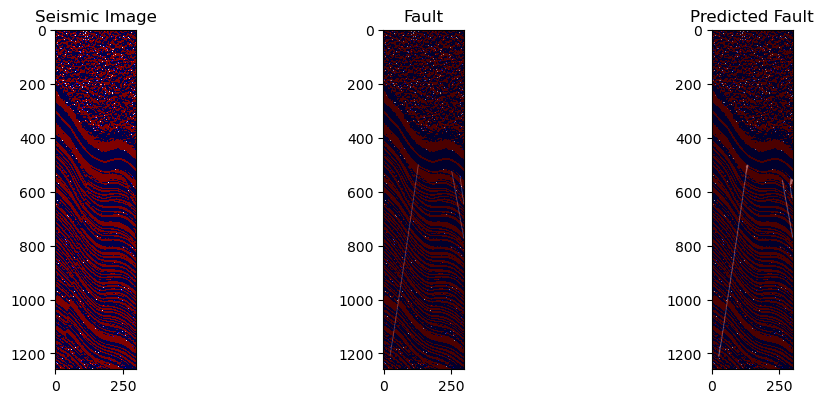

 40%|████      | 1156/2861 [1:45:48<3:06:12,  6.55s/it]

Epoch 4: Step 12600: U-Net loss: 0.19721204042434692


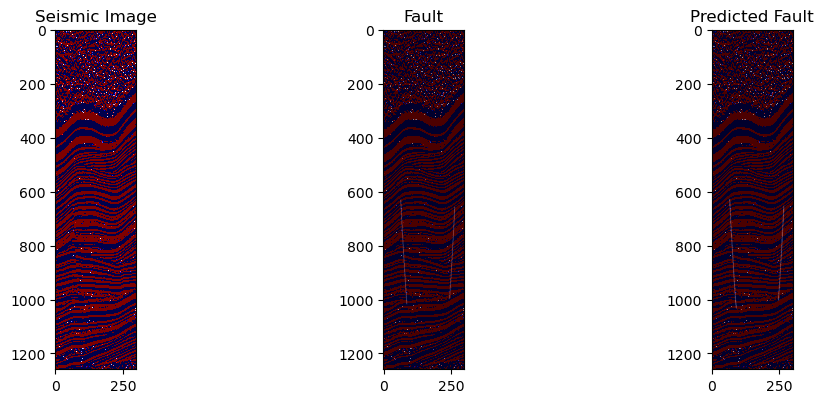

 42%|████▏     | 1206/2861 [1:50:13<2:22:55,  5.18s/it]

Epoch 4: Step 12650: U-Net loss: 0.21028399467468262


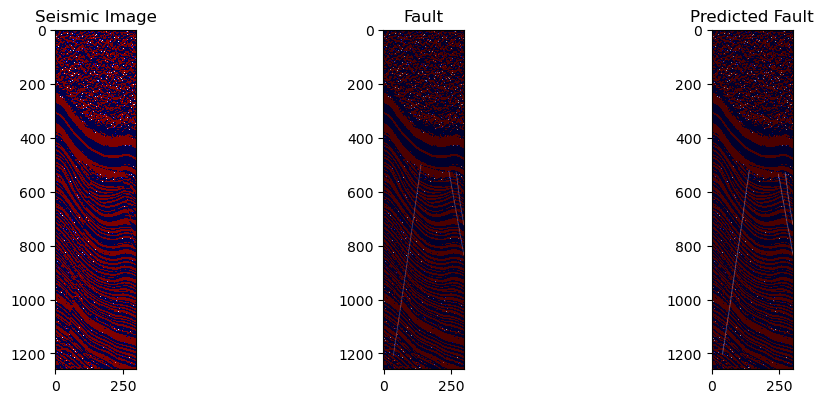

 44%|████▍     | 1256/2861 [1:55:50<1:42:02,  3.81s/it]

Epoch 4: Step 12700: U-Net loss: 0.2082858681678772


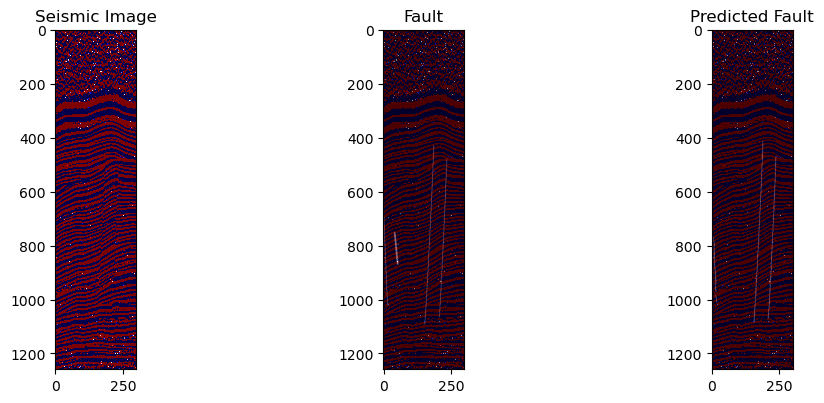

 46%|████▌     | 1306/2861 [1:59:54<1:41:14,  3.91s/it]

Epoch 4: Step 12750: U-Net loss: 0.1369578242301941


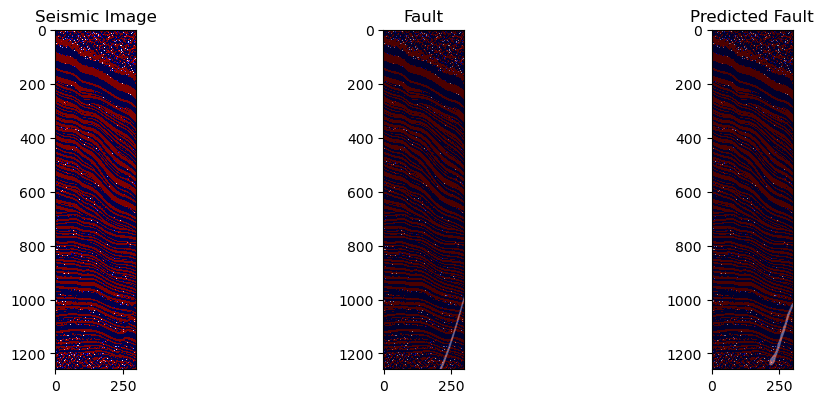

 47%|████▋     | 1356/2861 [2:06:01<3:45:18,  8.98s/it]

Epoch 4: Step 12800: U-Net loss: 0.15309667587280273


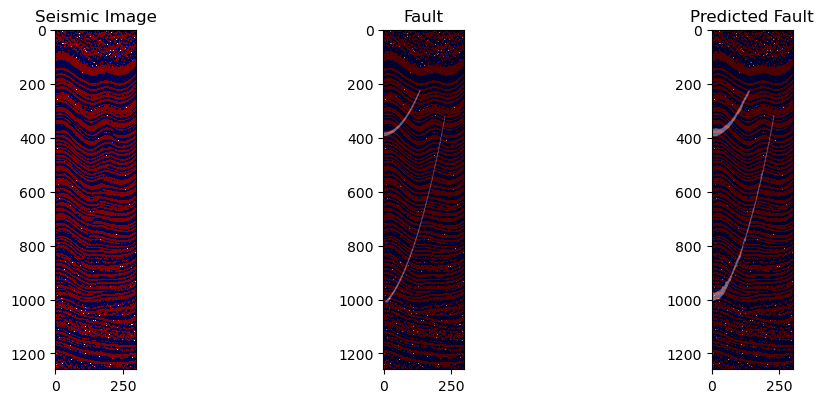

 49%|████▉     | 1406/2861 [2:30:53<4:26:38, 11.00s/it]  

Epoch 4: Step 12850: U-Net loss: 0.1815948486328125


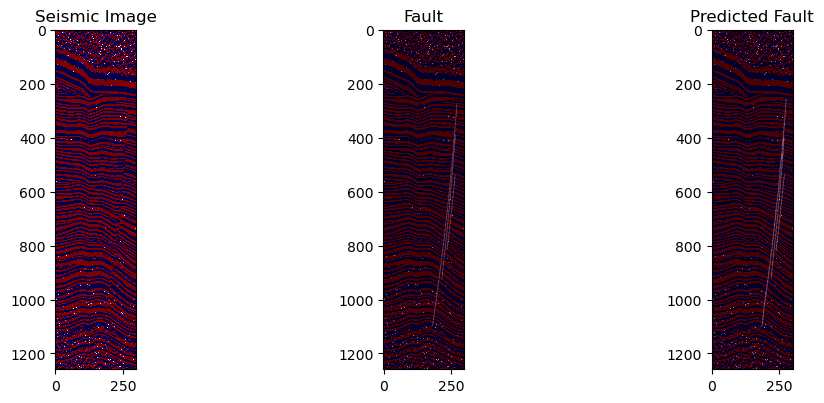

 51%|█████     | 1456/2861 [2:37:31<2:21:32,  6.04s/it]

Epoch 4: Step 12900: U-Net loss: 0.20726323127746582


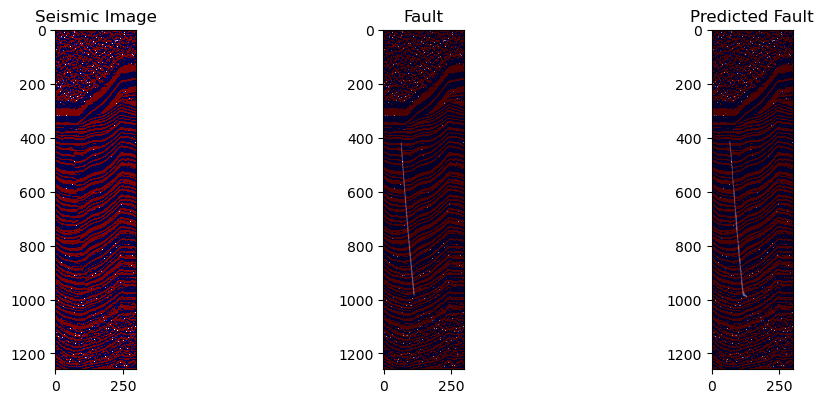

 53%|█████▎    | 1506/2861 [2:48:11<2:44:39,  7.29s/it] 

Epoch 4: Step 12950: U-Net loss: 0.17832809686660767


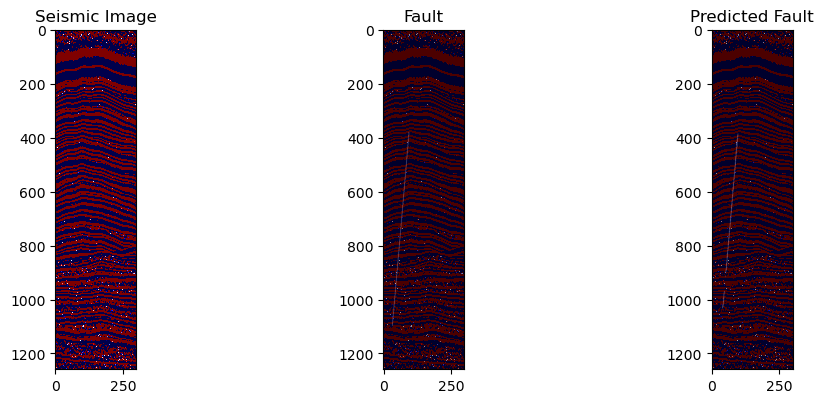

 54%|█████▍    | 1556/2861 [2:54:57<3:28:36,  9.59s/it]

Epoch 4: Step 13000: U-Net loss: 0.16367292404174805


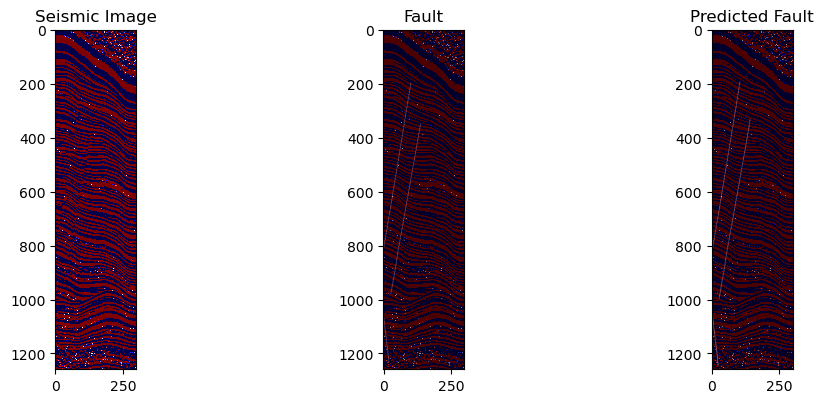

 56%|█████▌    | 1606/2861 [3:00:56<2:50:05,  8.13s/it]

Epoch 4: Step 13050: U-Net loss: 0.175836980342865


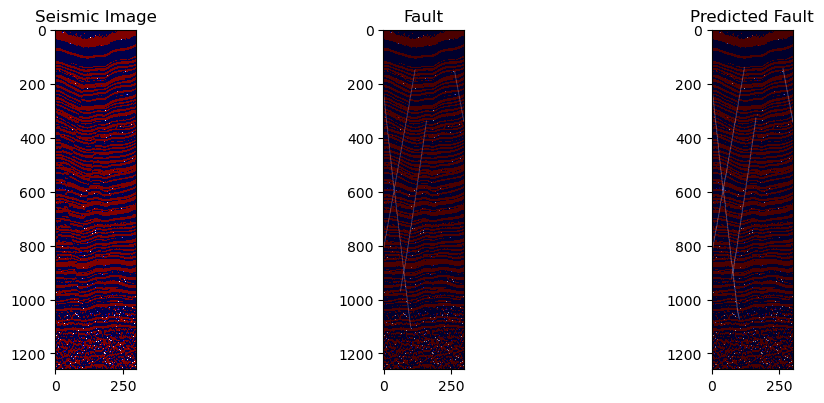

 58%|█████▊    | 1656/2861 [3:05:38<1:31:51,  4.57s/it]

Epoch 4: Step 13100: U-Net loss: 0.3258531093597412


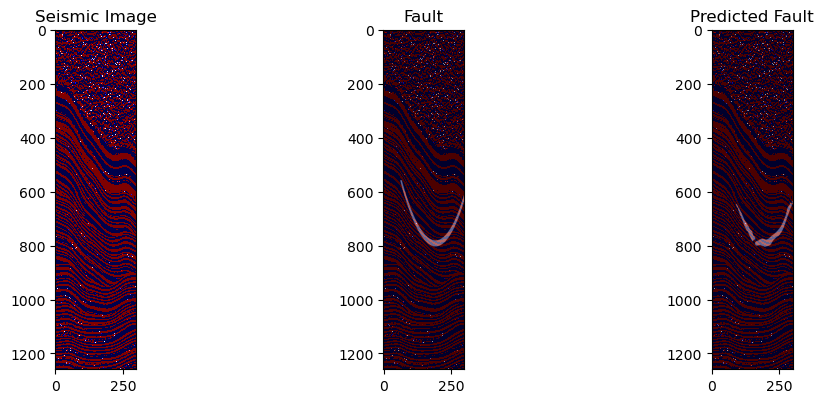

 60%|█████▉    | 1706/2861 [3:10:01<1:30:27,  4.70s/it]

Epoch 4: Step 13150: U-Net loss: 0.18165695667266846


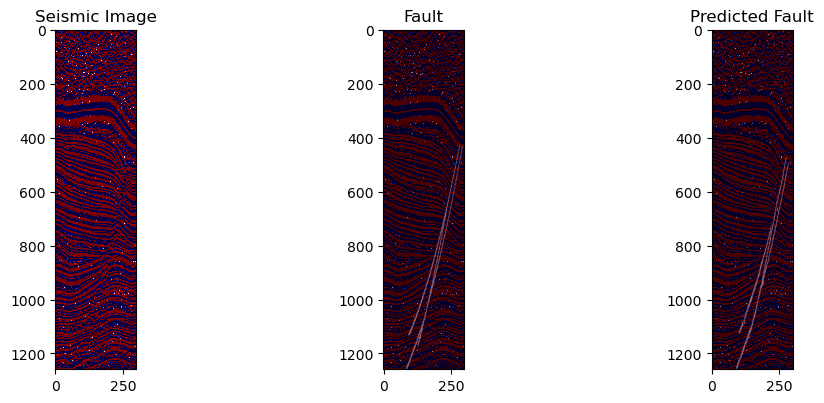

 61%|██████▏   | 1756/2861 [3:13:59<1:21:27,  4.42s/it]

Epoch 4: Step 13200: U-Net loss: 0.19603663682937622


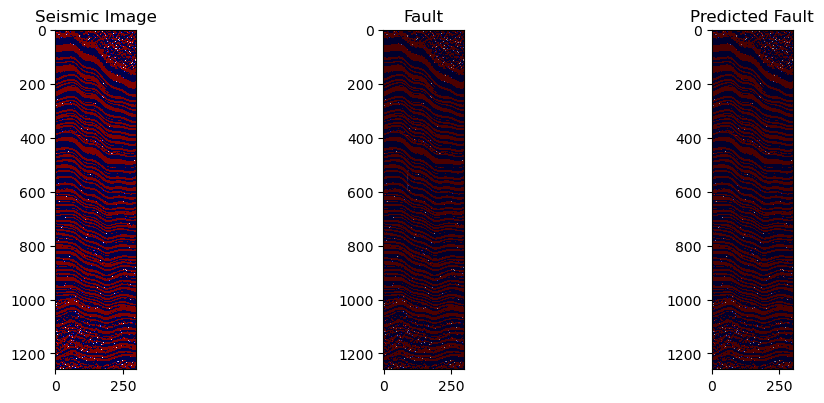

 63%|██████▎   | 1806/2861 [3:17:42<1:07:28,  3.84s/it]

Epoch 4: Step 13250: U-Net loss: 0.21955257654190063


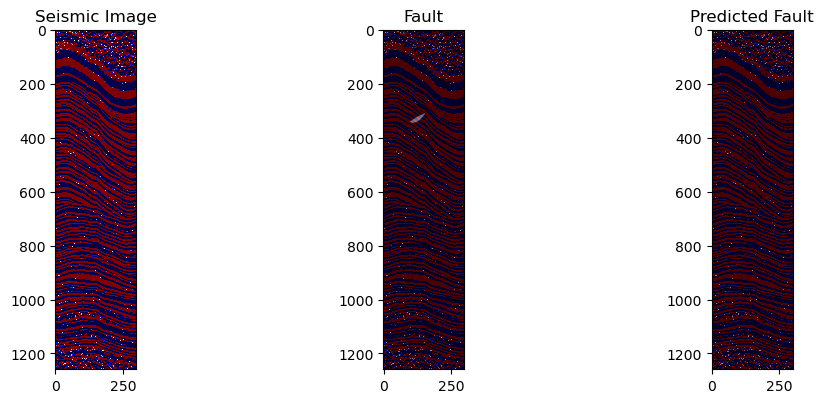

 65%|██████▍   | 1856/2861 [3:21:51<1:19:09,  4.73s/it]

Epoch 4: Step 13300: U-Net loss: 0.12265259027481079


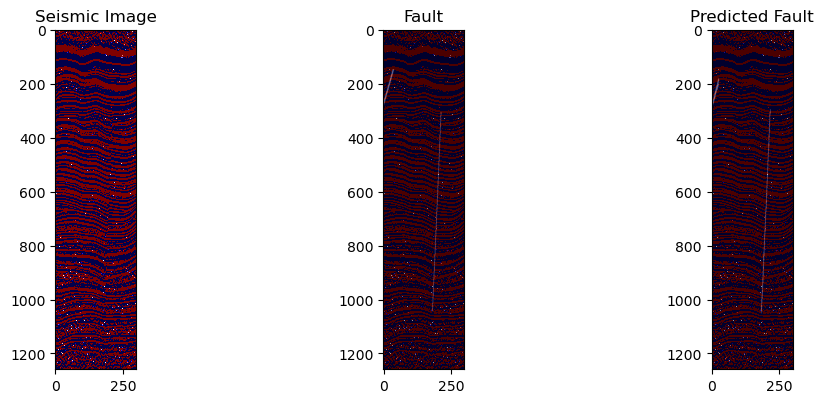

 67%|██████▋   | 1906/2861 [3:26:06<1:42:52,  6.46s/it]

Epoch 4: Step 13350: U-Net loss: 0.20317387580871582


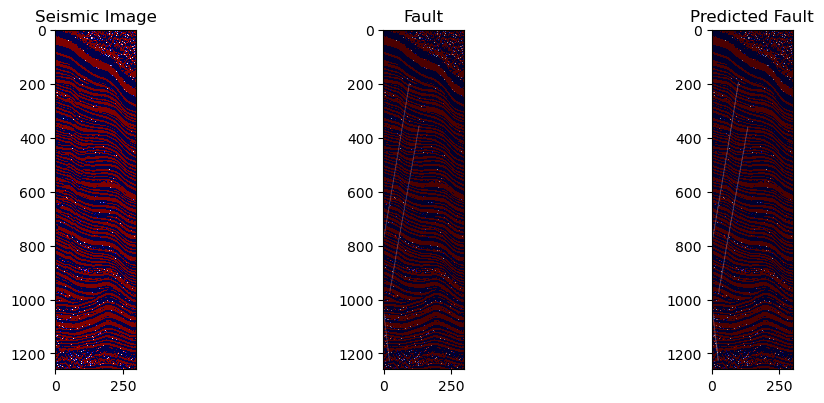

 68%|██████▊   | 1956/2861 [3:30:50<1:08:47,  4.56s/it]

Epoch 4: Step 13400: U-Net loss: 0.11609983444213867


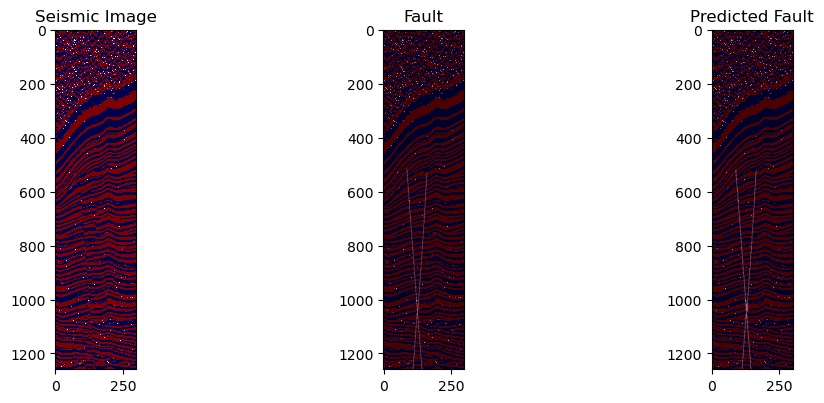

 70%|███████   | 2006/2861 [3:35:18<1:22:04,  5.76s/it]

Epoch 4: Step 13450: U-Net loss: 0.19158631563186646


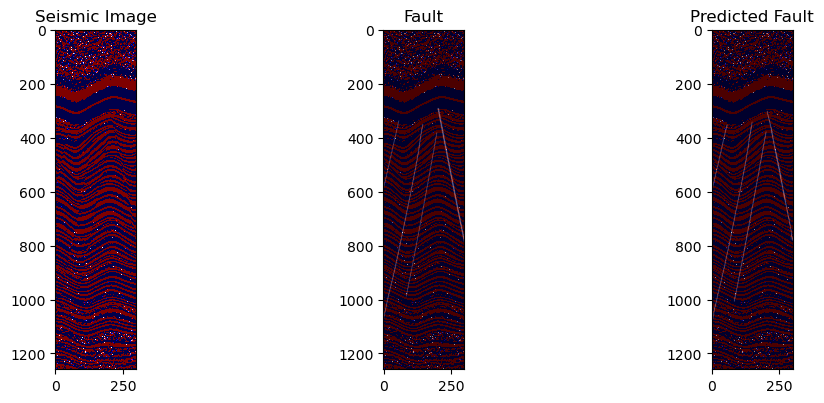

 72%|███████▏  | 2056/2861 [3:41:27<2:34:45, 11.53s/it]

Epoch 4: Step 13500: U-Net loss: 0.1654033660888672


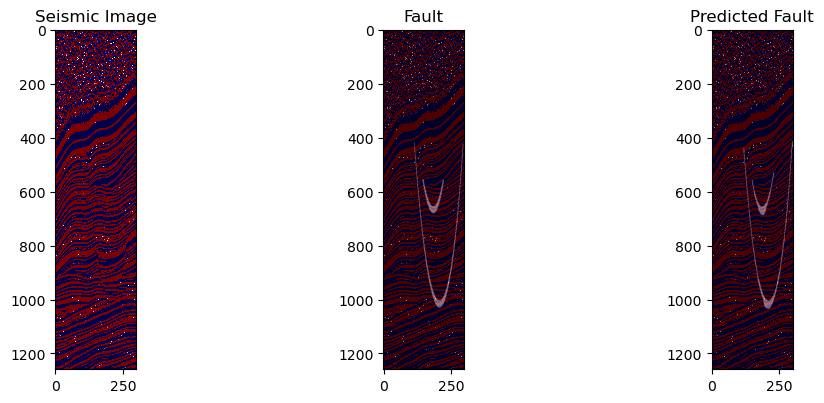

 74%|███████▎  | 2106/2861 [3:50:29<1:00:43,  4.83s/it] 

Epoch 4: Step 13550: U-Net loss: 0.2656840682029724


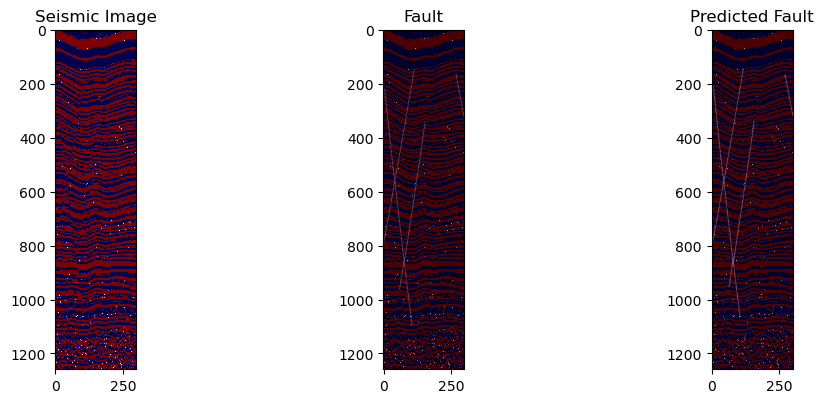

 75%|███████▌  | 2156/2861 [3:54:34<1:02:45,  5.34s/it]

Epoch 4: Step 13600: U-Net loss: 0.4589371085166931


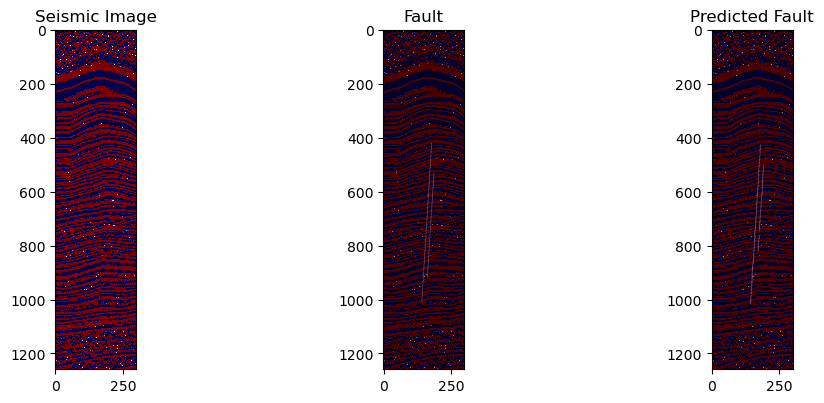

 77%|███████▋  | 2206/2861 [3:58:29<51:00,  4.67s/it]  

Epoch 4: Step 13650: U-Net loss: 0.19990932941436768


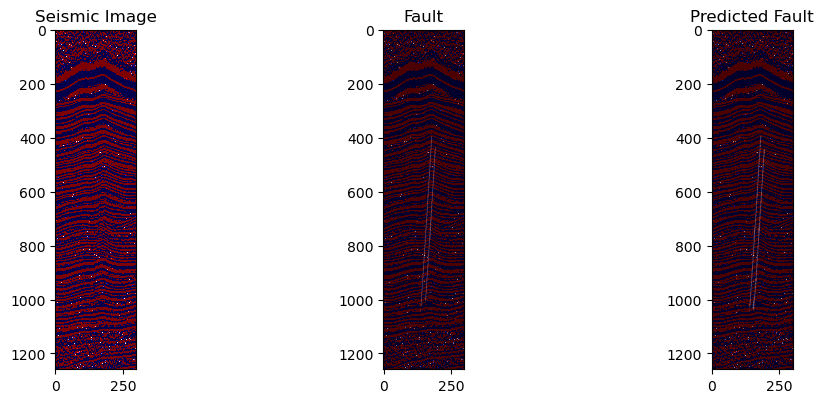

 79%|███████▉  | 2256/2861 [4:03:40<1:12:08,  7.15s/it]

Epoch 4: Step 13700: U-Net loss: 0.2171649932861328


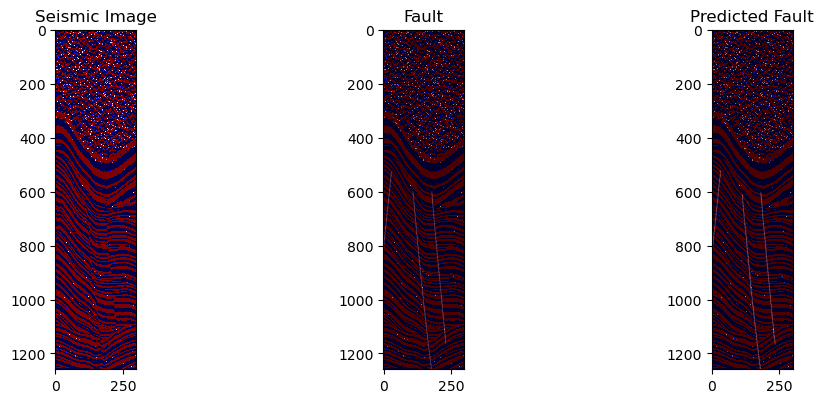

 81%|████████  | 2306/2861 [4:07:35<36:53,  3.99s/it]  

Epoch 4: Step 13750: U-Net loss: 0.17826062440872192


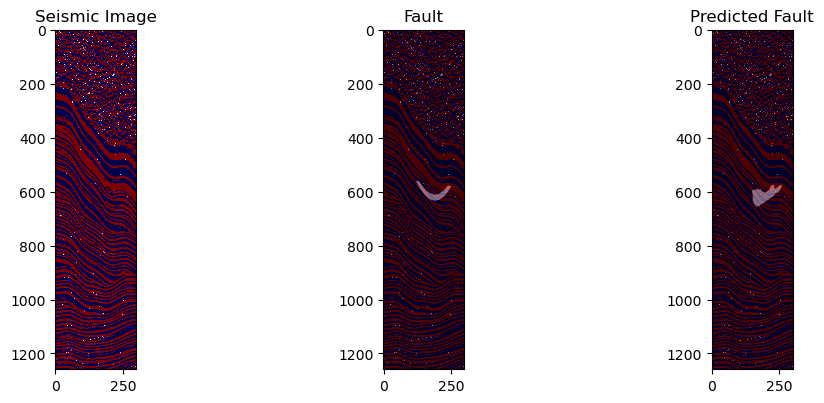

 82%|████████▏ | 2356/2861 [4:12:03<42:04,  5.00s/it]  

Epoch 4: Step 13800: U-Net loss: 0.1444656252861023


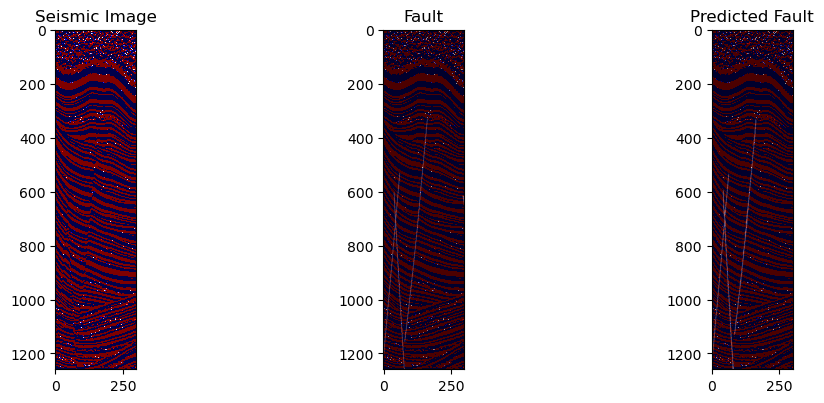

 84%|████████▍ | 2406/2861 [4:16:06<43:52,  5.79s/it]  

Epoch 4: Step 13850: U-Net loss: 0.15425258874893188


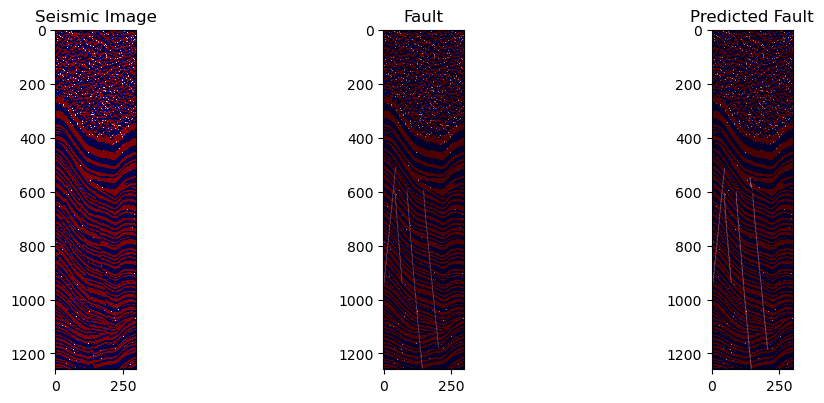

 86%|████████▌ | 2456/2861 [4:22:28<53:23,  7.91s/it]  

Epoch 4: Step 13900: U-Net loss: 0.3425586223602295


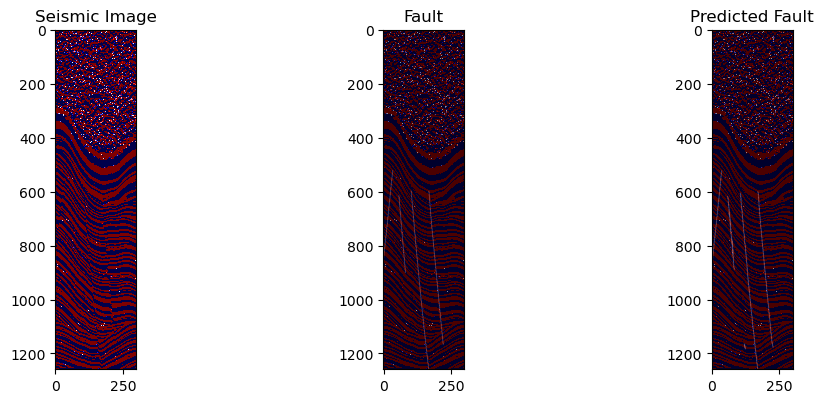

 88%|████████▊ | 2506/2861 [4:31:24<1:05:46, 11.12s/it]

Epoch 4: Step 13950: U-Net loss: 0.17023587226867676


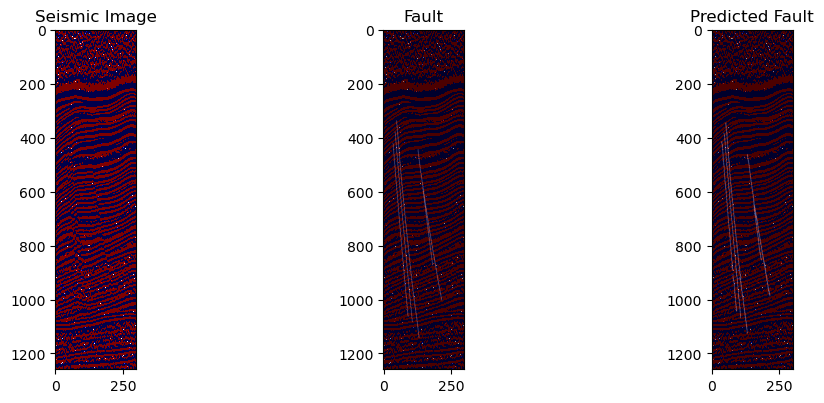

 89%|████████▉ | 2556/2861 [4:38:46<28:00,  5.51s/it]  

Epoch 4: Step 14000: U-Net loss: 0.18766480684280396


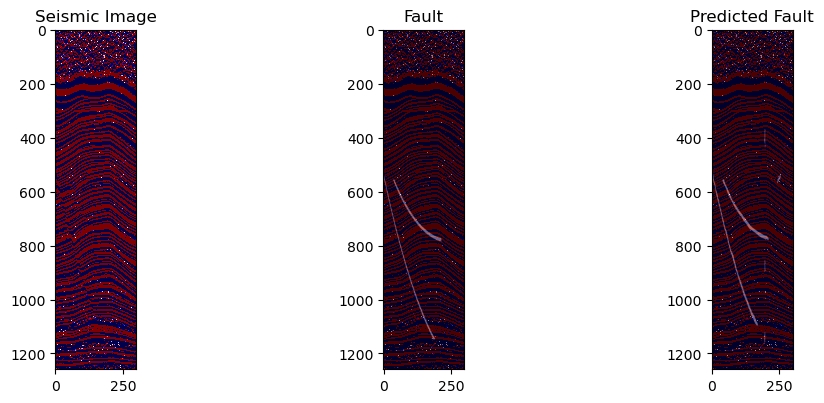

 91%|█████████ | 2606/2861 [4:45:39<24:28,  5.76s/it]

Epoch 4: Step 14050: U-Net loss: 0.2277735471725464


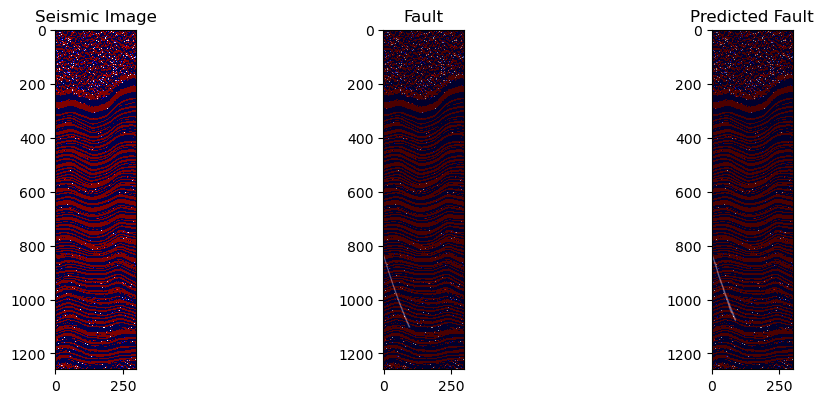

 93%|█████████▎| 2656/2861 [4:52:07<42:41, 12.50s/it]

Epoch 4: Step 14100: U-Net loss: 0.1425034999847412


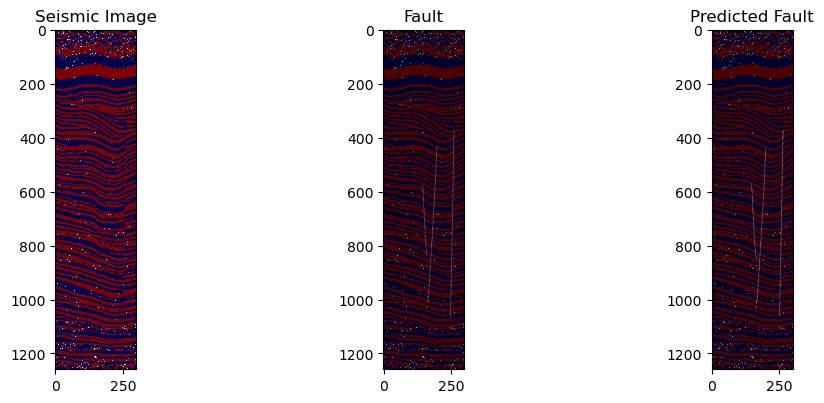

 95%|█████████▍| 2706/2861 [4:57:33<11:03,  4.28s/it]

Epoch 4: Step 14150: U-Net loss: 0.41032254695892334


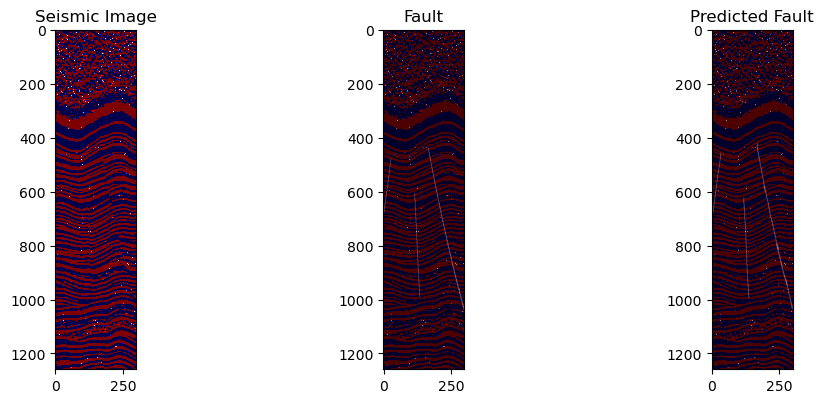

 96%|█████████▋| 2756/2861 [5:01:45<07:56,  4.54s/it]

Epoch 4: Step 14200: U-Net loss: 0.17919379472732544


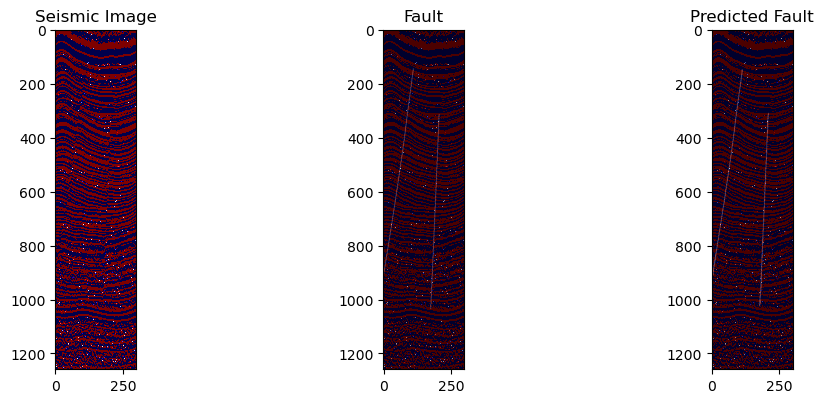

 98%|█████████▊| 2806/2861 [5:05:24<03:39,  4.00s/it]

Epoch 4: Step 14250: U-Net loss: 0.17693376541137695


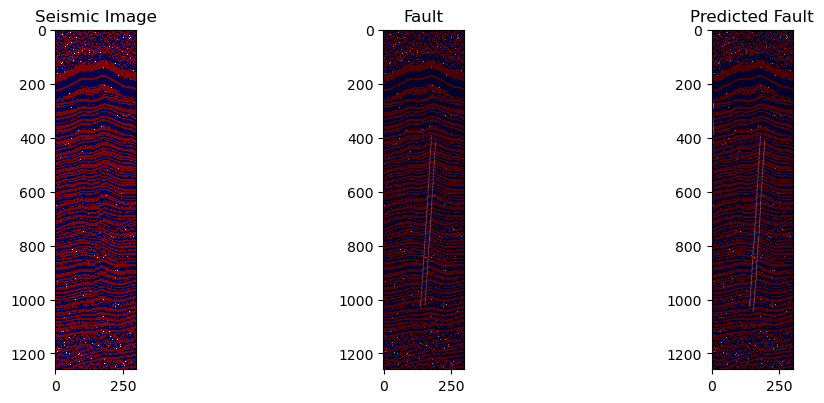

100%|█████████▉| 2856/2861 [5:09:01<00:18,  3.71s/it]

Epoch 4: Step 14300: U-Net loss: 0.1862366795539856


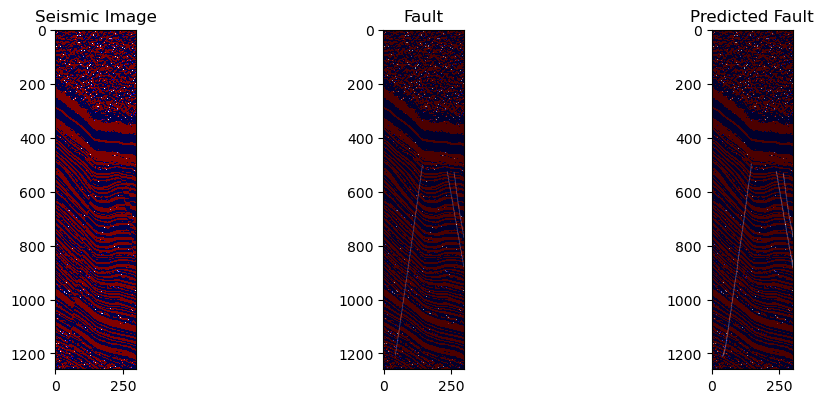

100%|██████████| 2861/2861 [5:09:25<00:00,  6.49s/it]


Checkpoint saved at epoch 5 to ///tmp/work/yutung/model_saved/unet_epoch_5.pth


In [21]:
checkpoint_path = "///tmp/work/yutung/model_saved/unet_epoch_3.pth"
# if __name__ == "__main__":
#     import argparse

#     parser = argparse.ArgumentParser()
#     parser.add_argument("--local_rank", type=int, default=0, help="Local GPU rank.")
#     args, unknown = parser.parse_known_args()

#     # 傳遞 local_rank 到 train 函數
#     unet, pred, loss = train(resume_training=True, checkpoint_path=None, local_rank=args.local_rank)

unet, pred, train_losses = train(resume_training=True, checkpoint_path=checkpoint_path)

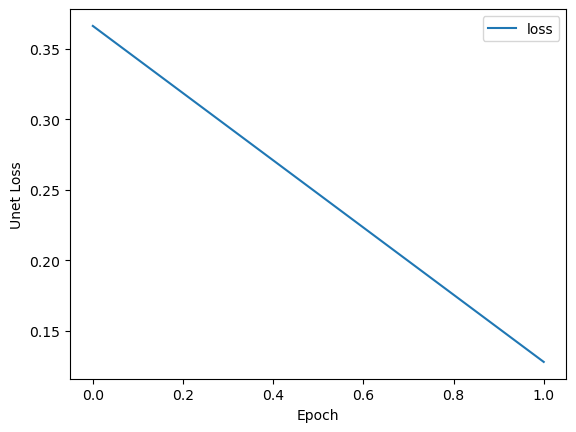

In [25]:
plt.plot(train_losses, label = 'loss')
plt.xlabel('Epoch')
plt.ylabel('Unet Loss')
plt.legend()
plt.show()